# reproduce figures in paper
This notebook is meant for release to the general public, to reproduce the figures from our paper "Multiple mechanisms mediate the suppression of motion vision during escape maneuvers in flying Drosophila" https://doi.org/10.1101/2022.02.03.478949 

# Setup imports
These imports are necessary to run the notebook. The production environment is listed in "working_environment.txt".


The custom pathdefs package is a convenience for the author to simplify running on different machines. It exports two variables SOURCEPATH and DATAPATH , which may just as well be declared as regular variables.

The paths where the respective files are to be found will be different for other users as well, of course. Adapt to your folder structure.

In [4]:
%matplotlib notebook

In [2]:
import os
from pathdefs import *
os.chdir(SOURCEPATH)
import importlib
import Looming_with_background_Analyzer as lwb
#import baseClasses as bc
from spontaneousAnalyzer import DummyAnalyzer

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import ndimage
import glob
import helperLibrary
import pickle
# import re
# import copy

In [3]:
optomotorColor = np.array([75,75,75])/255
optomotorAlpha = 0.2
plotColors = [(.0, 100/255, 178/255), # blueish
              (54/255, 170/255, 80/255), # some green
              (200/255, 74/255, .0), # orange-red
              optomotorColor]
plotAlphas = [0.3, # same order as colors
             0.38,
             0.31,
             optomotorAlpha]

In [4]:
PLOT_TIMEWINDOW = [-0.65,0.46] # for most plots

In [5]:
# DEPENDENT ON PRECISE FOLDER STRUCTURE, PROBABLY DIFFERENT FOR ANYONE ELSE
# ADJUST THIS!!

saccLeft_HyPol = [('vonBettina/25072018_CS', 'Fly1_WTCS_age_3d_cell1_'),
                  ('vonBettina/13022019_G06', 'Fly1_U29xG06_age_3d_cell1_'),
                  ('vonBettina/26072019_CS', 'Fly1_WTCS_age_3d_cell1_'),
                  ('2020_01_29', 'Fly3_U29xG16_age_5d_cell1_'),
                  ('2020_03_16', 'Fly1_X20a_age_3d_cell1_'), 
                  ('2020_04_20', 'fly4_X21_age_3d_cell1_') ]
saccLeft_DePol = [('vonBettina/06112019_CS', 'Fly1_WTCS_age_3d_cell1_'),
                  ('2020_01_29', 'Fly1_U29xG16_age_5d_cell1_') ]
saccLeft_NoPol = [('vonBettina/04112019_G06', 'Fly1_G06xU29_age_3d_cell1_'),
                  ('2019_12_09', 'Fly1_U29xG16_age_2d_cell2_'),
                  ('2020_04_15', 'Fly3_X21_age_3d_cell1_'),
                  ('2020_04_17', 'Fly3_X21_age_5d_cell1_'),
                  ('2021_02_17', 'fly2_X20_age_2d_cell1_') ]

In [6]:
# refer to https://gist.github.com/dmeliza/3251476
# dmeliza     dmeliza/scalebars.py 
from matplotlib.offsetbox import AnchoredOffsetbox
class AnchoredScaleBar(AnchoredOffsetbox):
    def __init__(self, transform, sizex=0, sizey=0, labelx=None, labely=None, loc=4,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, barcolor="black", barwidth=None, 
                 **kwargs):
        """
        Draw a horizontal and/or vertical  bar with the size in data coordinate
        of the give axes. A label will be drawn underneath (center-aligned).
        - transform : the coordinate frame (typically axes.transData)
        - sizex,sizey : width of x,y bar, in data units. 0 to omit
        - labelx,labely : labels for x,y bars; None to omit
        - loc : position in containing axes
        - pad, borderpad : padding, in fraction of the legend font size (or prop)
        - sep : separation between labels and bars in points.
        - **kwargs : additional arguments passed to base class constructor
        """
        from matplotlib.patches import Rectangle
        from matplotlib.offsetbox import AuxTransformBox, VPacker, HPacker, TextArea, DrawingArea
        bars = AuxTransformBox(transform)
        if sizex:
            bars.add_artist(Rectangle((0,0), sizex, 0, ec=barcolor, lw=barwidth, fc="none"))
        if sizey:
            bars.add_artist(Rectangle((0,0), 0, sizey, ec=barcolor, lw=barwidth, fc="none"))

        if sizex and labelx:
            self.xlabel = TextArea(labelx, minimumdescent=False, textprops={'fontname':'arial', 'fontsize':8.})
            bars = VPacker(children=[bars, self.xlabel], align="center", pad=0, sep=sep)
        if sizey and labely:
            self.ylabel = TextArea(labely, textprops={'fontname':'arial', 'fontsize':8.})
            bars = HPacker(children=[self.ylabel, bars], align="center", pad=0, sep=sep)

        AnchoredOffsetbox.__init__(self, loc, pad=pad, borderpad=borderpad,
                                   child=bars, prop=prop, frameon=False, **kwargs)

        
def add_scalebar(ax, matchx=True, matchy=True, hidex=True, hidey=True, **kwargs):
    """ Add scalebars to axes
    Adds a set of scale bars to *ax*, matching the size to the ticks of the plot
    and optionally hiding the x and y axes
    - ax : the axis to attach ticks to
    - matchx,matchy : if True, set size of scale bars to spacing between ticks
                    if False, size should be set using sizex and sizey params
    - hidex,hidey : if True, hide x-axis and y-axis of parent
    - **kwargs : additional arguments passed to AnchoredScaleBars
    Returns created scalebar object
    """
    def f(axis):
        l = axis.get_majorticklocs()
        return len(l)>1 and (l[1] - l[0])
    
    if matchx:
        kwargs['sizex'] = f(ax.xaxis)
        kwargs['labelx'] = str(kwargs['sizex'])
    if matchy:
        kwargs['sizey'] = f(ax.yaxis)
        kwargs['labely'] = str(kwargs['sizey'])
        
    sb = AnchoredScaleBar(ax.transData, **kwargs)
    ax.add_artist(sb)

    if hidex : ax.xaxis.set_visible(False)
    if hidey : ax.yaxis.set_visible(False)
    if hidex and hidey: ax.set_frame_on(False)

    return sb

# Figure 1
## Fig 1D

## Fig 1E

In [6]:
saSacc_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_saccading.neomat'))
saStrg_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_straight.neomat'))

In [7]:
# keep only one fly
saSacc_Rhyp.clean_flyIDs()
rm = np.where(saSacc_Rhyp.fly_indices!=3)[0]
saSacc_Rhyp.remove_duds_byList(rm)

saStrg_Rhyp.clean_flyIDs()
rm = np.where(saStrg_Rhyp.fly_indices!=3)[0]
saStrg_Rhyp.remove_duds_byList(rm)

saSacc_Rhyp.clean_flyIDs()
saStrg_Rhyp.clean_flyIDs()
saSacc_Rhyp.reallocate_fly_indices()
saStrg_Rhyp.reallocate_fly_indices()

print(saSacc_Rhyp.flyID)
print(saStrg_Rhyp.flyID)

{0: 'fly1_WTCS_20190726_cell1'}
{0: 'fly1_WTCS_20190726_cell1'}


In [8]:
# keep only looming left trials
stimID = 2
saStrg_Rhyp.remove_duds_byList(np.where(saStrg_Rhyp.group_indices!=stimID)[0])
saSacc_Rhyp.remove_duds_byList(np.where(saSacc_Rhyp.group_indices!=stimID)[0])

<IPython.core.display.Javascript object>


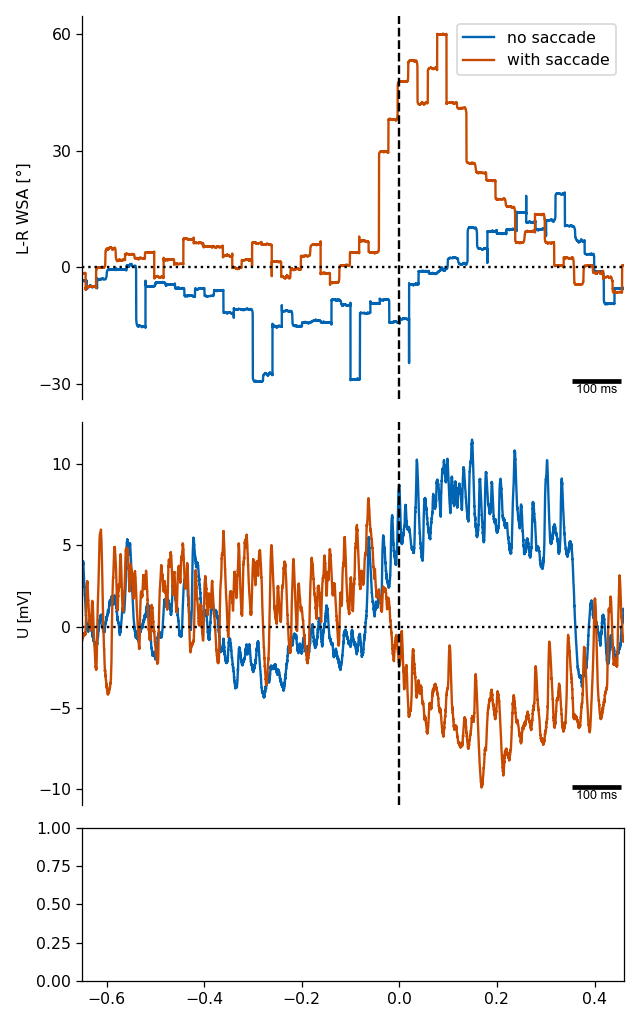

In [15]:
fig, axes = plt.subplots(3,1, figsize=(5,8),sharex='all', gridspec_kw={'height_ratios': [2.5,2.5,1]})

### ephys

In [16]:
saSacc = saSacc_Rhyp
saStrg = saStrg_Rhyp

f,ax = fig, axes[1]

maxLoom = (saSacc.preStim+saSacc.stimulusPhases_inframes[1]*saSacc.meanFramePeriod)*saSacc.samplingRate
timeLims = [int(maxLoom+PLOT_TIMEWINDOW[0]*saSacc.samplingRate), int(maxLoom+PLOT_TIMEWINDOW[1]*saSacc.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc.samplingRate+PLOT_TIMEWINDOW[0]

d = saStrg.segments[0].data[saStrg.channelmap['ephys']]*100. # factor of 100 converts to mV
ax.plot(timeSlice, d[timeLims[0]:timeLims[1]], color=plotColors[0])

d = saSacc.segments[1].data[saSacc.channelmap['ephys']]*100.
ax.plot(timeSlice, d[timeLims[0]:timeLims[1]], color=plotColors[2])

ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle=':', color='k')
# ax.legend(['no saccade','with saccade'], font='Arial')
ax.set_ylabel('U [mV]', fontname='Arial')
plt.tight_layout()

In [17]:
ax.xaxis.set_visible(False)
ax.set_xlim(PLOT_TIMEWINDOW)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, hidey=False, sizey=0.0, barwidth=3)
plt.tight_layout()

### wingDiff

In [18]:
saSacc = saSacc_Rhyp
saStrg = saStrg_Rhyp

f,ax = fig, axes[0]
# f,ax=plt.subplots(1,1)

preSacc = 0.8 #s
postSacc = 0.5 #s
maxLoom = (saSacc.preStim+saSacc.stimulusPhases_inframes[1]*saSacc.meanFramePeriod)*saSacc.samplingRate
timeLims = [int(maxLoom+PLOT_TIMEWINDOW[0]*saSacc.samplingRate), int(maxLoom+PLOT_TIMEWINDOW[1]*saSacc.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc.samplingRate+PLOT_TIMEWINDOW[0]

d = saStrg.segments[0].data[saStrg.channelmap['wingDiff']]*100.
ax.plot(timeSlice, d[timeLims[0]:timeLims[1]], color=plotColors[0])

d = saSacc.segments[1].data[saSacc.channelmap['wingDiff']]*100.
ax.plot(timeSlice, d[timeLims[0]:timeLims[1]], color=plotColors[2])

ax.axvline(0, linestyle='--', color='k')
ax.axhline(0, linestyle=':', color='k')
ax.legend(['no saccade','with saccade'])
ax.set_ylabel('L-R WSA [°]')
plt.tight_layout()

In [19]:
ax.xaxis.set_visible(False)
ax.set_yticks([-30,0,30,60])
ax.set_xlim(PLOT_TIMEWINDOW)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, hidey=False, sizey=0.0, barwidth=3)

### visual angle of looming

<IPython.core.display.Javascript object>


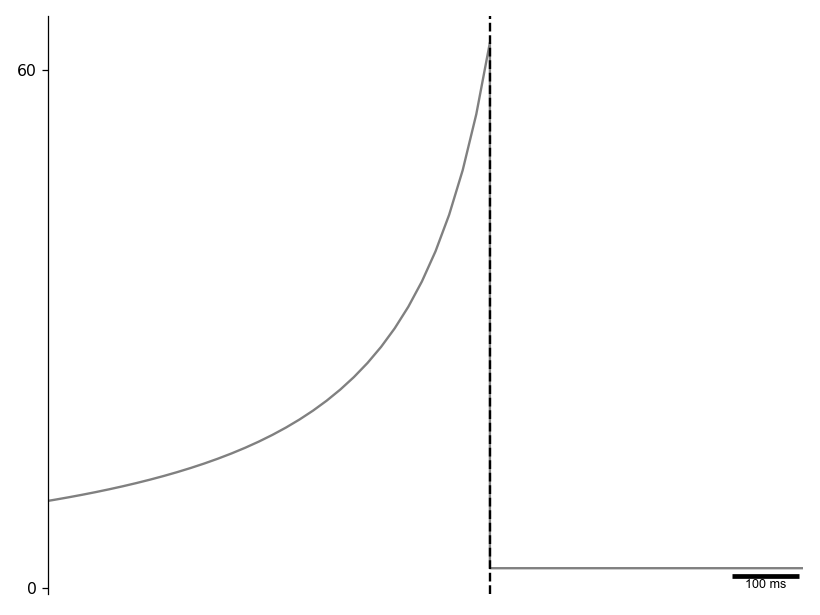

In [20]:
preSacc = 0.8 #s
postSacc = 0.5 #s

h=0.1 #m
v=1.5 #m/s
t0 = -h/v*1/np.tan(76.5/2) #76.5 is maximal angle (=34[px]*2.25[°/px])
theta = lambda t: 2*np.arctan(-h/v/(t+t0))*180/np.pi #in °
t_loom = np.arange(0.0, -preSacc, -1/50.)[::-1]
t_after = np.arange(0, postSacc, 1/50)
t_all = np.append(t_loom,t_after)

f,ax=plt.subplots(1,1)
ax.plot(t_all, np.append(theta(t_loom),np.full_like(t_after, 2.25)), color=[0.5]*3)
ax.axvline(0, linestyle='--', color='k')
plt.tight_layout()

In [21]:
ax.xaxis.set_visible(False)
ax.set_yticks([0,60])
ax.set_xlim(PLOT_TIMEWINDOW)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, hidey=False, sizey=0.0, barwidth=3)
plt.tight_layout()

# Figure 2

## loading data for Fig 2A&B

In [22]:
# LOAD ALL SACCADE TRIALS OF ALL FLIES

anlyz=[None]*2
anlyz[0] = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_HyPol__CWTdetection_saccading.neomat'))
anlyz[1] = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_NoPol__CWTdetection_saccading.neomat'))
# anlyz[2] = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
#                             'Collections_saccade_straight',
#                             'saccLeft_DePol__CWTdetection_saccading.neomat'))
saSacc = sum(anlyz)
saSacc.average_flywise()

In [23]:
saSacc.flyID

{0: 'fly1_WTCS_20180725_cell1',
 1: 'fly4_X21_20200420_cell1',
 2: 'fly1_U29xG06_20190213_cell1',
 3: 'fly1_WTCS_20190726_cell1',
 4: 'fly3_U29xG16_20200129_cell1',
 5: 'fly1_X20a_20200316_cell1',
 6: 'fly1_G06xU29_20191104_cell1',
 7: 'fly1_U29xG16_20191209_cell2',
 8: 'fly3_X21_20200415_cell1',
 9: 'fly3_x21_20200417_cell1',
 10: 'fly2_X20_20210217_cell1'}

In [24]:
# LOAD ALL STRAIGHT TRIALS OF ALL FLIES

# anlyz=[None,None, None]
anlyz=[None,None]
anlyz[0] = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_HyPol__CWTdetection_straight.neomat'))
anlyz[1] = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_NoPol__CWTdetection_straight.neomat'))
# anlyz[2] = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
#                              'Collections_saccade_straight',
#                              'saccLeft_DePol__CWTdetection_straight.neomat'))
saStrg = sum(anlyz)
saStrg.average_flywise()

In [25]:
saStrg.flyID

{0: 'fly1_WTCS_20180725_cell1',
 1: 'fly4_X21_20200420_cell1',
 2: 'fly1_U29xG06_20190213_cell1',
 3: 'fly1_WTCS_20190726_cell1',
 4: 'fly3_U29xG16_20200129_cell1',
 5: 'fly1_X20a_20200316_cell1',
 6: 'fly1_G06xU29_20191104_cell1',
 7: 'fly1_U29xG16_20191209_cell2',
 8: 'fly3_X21_20200415_cell1',
 9: 'fly3_x21_20200417_cell1',
 10: 'fly2_X20_20210217_cell1'}

## Fig 2A
L-R WBA of saccades and non-saccade trials

<IPython.core.display.Javascript object>


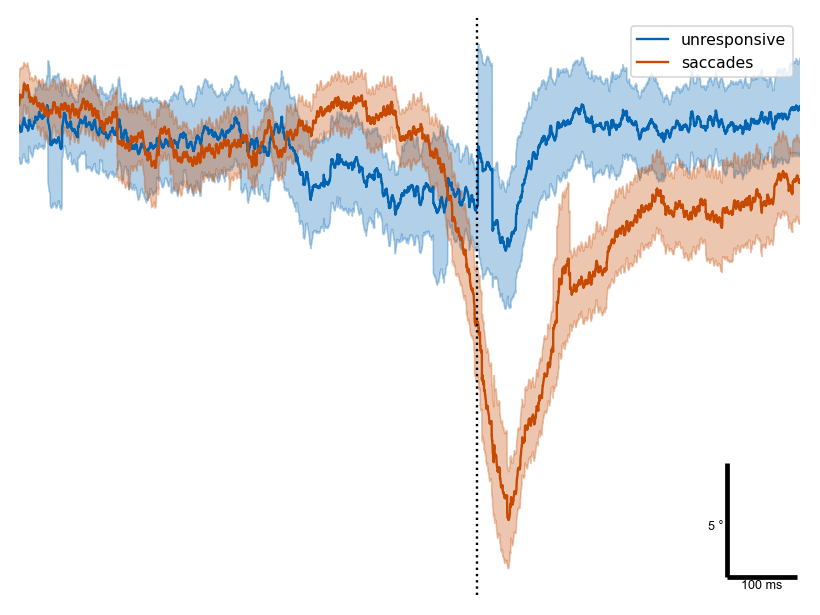

In [28]:
preSacc = 0.7 #s
postSacc = 0.5 #s
maxLoom = (saSacc.preStim+saSacc.stimulusPhases_inframes[1]*saSacc.meanFramePeriod)*saSacc.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc.samplingRate), int(maxLoom+postSacc*saSacc.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc.samplingRate-preSacc#-saSacc[i].preStim

f,ax=plt.subplots(1,1)

d = saStrg.get_avg_data('wingDiff')
s = saStrg.get_std_data('wingDiff')
# convert from radians to degrees
d = {k:v*180./np.pi for k,v in d.items()}
s = {k:v*180./np.pi for k,v in s.items()}

ax.plot(timeSlice, d[5][timeLims[0]:timeLims[1]], color=plotColors[0])
ax.fill_between(timeSlice, (d[5]+s[5])[timeLims[0]:timeLims[1]], (d[5]-s[5])[timeLims[0]:timeLims[1]],
                color=plotColors[0], alpha=plotAlphas[0])

d = saSacc.get_avg_data('wingDiff')
s = saSacc.get_std_data('wingDiff')
# convert from radians to degrees
d = {k:v*180./np.pi for k,v in d.items()}
s = {k:v*180./np.pi for k,v in s.items()}

ax.plot(timeSlice, d[5][timeLims[0]:timeLims[1]],  color=plotColors[2])
ax.fill_between(timeSlice, (d[5]+s[5])[timeLims[0]:timeLims[1]], (d[5]-s[5])[timeLims[0]:timeLims[1]],
                color=plotColors[2], alpha=plotAlphas[2])

ax.set_ylabel('L-R WBA [°]')
ax.set_xlabel('time [s]')
ax.legend(['unresponsive','saccades'])
ax.axvline(0., color='k', linestyle=':') #marks ends of looming

ax.set_xlim(PLOT_TIMEWINDOW)
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=5., labely='5 °',  barwidth=3)
plt.tight_layout()

## Fig 2B
Run section before figure 2A first to load all the data

<IPython.core.display.Javascript object>


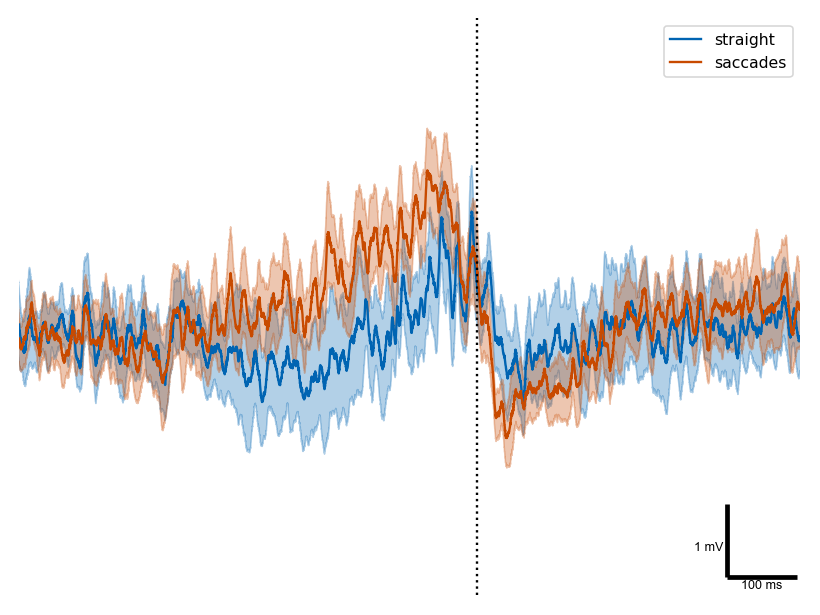

In [29]:

preSacc = 0.7 #s
postSacc = 0.5 #s
maxLoom = (saSacc.preStim+saSacc.stimulusPhases_inframes[1]*saSacc.meanFramePeriod)*saSacc.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc.samplingRate), int(maxLoom+postSacc*saSacc.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc.samplingRate-preSacc#-saSacc[i].preStim

f,ax=plt.subplots(1,1)

d = saStrg.get_avg_data('ephys')
s = saStrg.get_std_data('ephys')
# conversion from raw amplifier output to mV
d = {k:v*100. for k,v in d.items()}
s = {k:v*100. for k,v in s.items()}

ax.plot(timeSlice, d[5][timeLims[0]:timeLims[1]], color=plotColors[0])
ax.fill_between(timeSlice, (d[5]+s[5])[timeLims[0]:timeLims[1]], (d[5]-s[5])[timeLims[0]:timeLims[1]],
                color=plotColors[0], alpha=plotAlphas[0])

d = saSacc.get_avg_data('ephys')
s = saSacc.get_std_data('ephys')
# conversion from raw amplifier output to mV
d = {k:v*100. for k,v in d.items()}
s = {k:v*100. for k,v in s.items()}

ax.plot(timeSlice, d[5][timeLims[0]:timeLims[1]], color=plotColors[2])
ax.fill_between(timeSlice, (d[5]+s[5])[timeLims[0]:timeLims[1]], (d[5]-s[5])[timeLims[0]:timeLims[1]], color=plotColors[2], alpha=plotAlphas[2])

ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.legend(['straight','saccades'])
ax.axvline(0., color='k', linestyle=':') # marks end of looming

ax.set_xlim(PLOT_TIMEWINDOW)
ax.set_ylim([-3.5,4.5])
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=1., labely='1 mV', barwidth=3)
plt.tight_layout()

## loading data for Fig 2C&D
loads data and calculates amplitudes of membrane polarizations and L-R WSA for spontaneous saccades tp the left for setting line colors

In [30]:
folder = os.path.join(DATAPATH, 'spontaneousSaccades','CWTdetection')
#dirlist = os.lsdir(folder)
flist = glob.glob(os.path.join(folder,'*.neomat'))
remove = [i for i,f in enumerate(flist) if '20191025' in f] #too noisy, not used in other plots either
assert(len(remove)==1)
del flist[remove[0]]
flist

['D:\\RecorderData\\spontaneousSaccades\\CWTdetection\\fly1_g06xu29_20191104_cell1_looming_wb_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\CWTdetection\\fly1_u29xg06_20190213_cell1_looming_wb_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\CWTdetection\\fly1_u29xg16_20191209_cell2_looming_wb_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\CWTdetection\\fly1_u29xg16_20200129_cell1_looming_wb_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\CWTdetection\\fly1_wtcs_20180725_cell1_looming_wb_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\CWTdetection\\fly1_wtcs_20190726_cell1_looming_wb_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\CWTdetection\\fly1_wtcs_20191106_cell1_looming_wb_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\CWTdetection\\fly1_x20a_20200316_cell1_looming_wb_spontSac

In [31]:
allSaccLeftMeanEphys = {}
allSaccLeftMeanWBA = {}
allSaccRightMeanEphys = {}
allSaccRightMeanWBA = {}

for fn in flist:
    # load file into appropriate data structure (minimal subclass of BaseClass that keeps inter-trial intervals)
    da = DummyAnalyzer.retrieveFromNeomatfile(fn)
    #in some instances the ephys data has been saved as *100 (like used for plotting), so put all on same scale
    if max(abs(da.saccLeftMeanEphys)) >0.1:
        da.saccLeftMeanEphys /= 100.
        da.saccRightMeanEphys /= 100.
    # apply resampling where necessary
    if abs(da.samplingRate -10000) >10: #not >0 because original double from MatLab was read with sligh deviation by Python (>1 should be sufficient)
        #print('resampling ',fn)
        da.saccLeftMeanEphys = signal.resample(da.saccLeftMeanEphys, int(da.saccLeftMeanEphys.size/da.samplingRate*10000.))
        da.saccRightMeanEphys = signal.resample(da.saccRightMeanEphys, int(da.saccRightMeanEphys.size/da.samplingRate*10000.))
        da.saccLeftMeanWBA = signal.resample(da.saccLeftMeanWBA, int(da.saccLeftMeanWBA.size/da.samplingRate*10000.))
        da.saccRightMeanWBA = signal.resample(da.saccRightMeanWBA, int(da.saccRightMeanWBA.size/da.samplingRate*10000.))
    # keep results in dict
    allSaccLeftMeanEphys[da.flyID[0]] = da.saccLeftMeanEphys
    allSaccRightMeanEphys[da.flyID[0]] = da.saccRightMeanEphys
    # convert L-R WSA (=WBA) to degrees
    allSaccLeftMeanWBA[da.flyID[0]] = da.saccLeftMeanWBA*180./np.pi
    allSaccRightMeanWBA[da.flyID[0]] = da.saccRightMeanWBA*180./np.pi

plotlist = list(allSaccLeftMeanEphys.keys())[:]


In [32]:
#determine amplitudes of membrane polarizations and L-R WSA to attribute colors to line plots

polAmp=[] #polarizationAmplitude
polAmp_dict={}
saccAmp=[] #saccadeAmplitude
saccAmp_dict={}
for flyid in plotlist:
    d=allSaccLeftMeanEphys[flyid]
    d = ndimage.gaussian_filter1d(d, 60)
    ix = int(np.argmax(signal.medfilt(np.abs(d[int(0.15*10000):]), 101))+0.15*10000)
    polAmp.append(d[ix])
    polAmp_dict[flyid] = d[ix]
    
    d=allSaccLeftMeanWBA[flyid]
    d = ndimage.gaussian_filter1d(d, 60)
    ix = int(np.argmax(signal.medfilt(np.abs(d[int(0.15*10000):]), 101))+0.15*10000)
    saccAmp.append(d[ix])
    saccAmp_dict[flyid] = d[ix]
polAmp = np.array(polAmp)
saccAmp = np.array(saccAmp)

## Fig 2C
Plot L-R WBA of spontaneous saccades to the left, meaning R>L and L-R<0

<IPython.core.display.Javascript object>


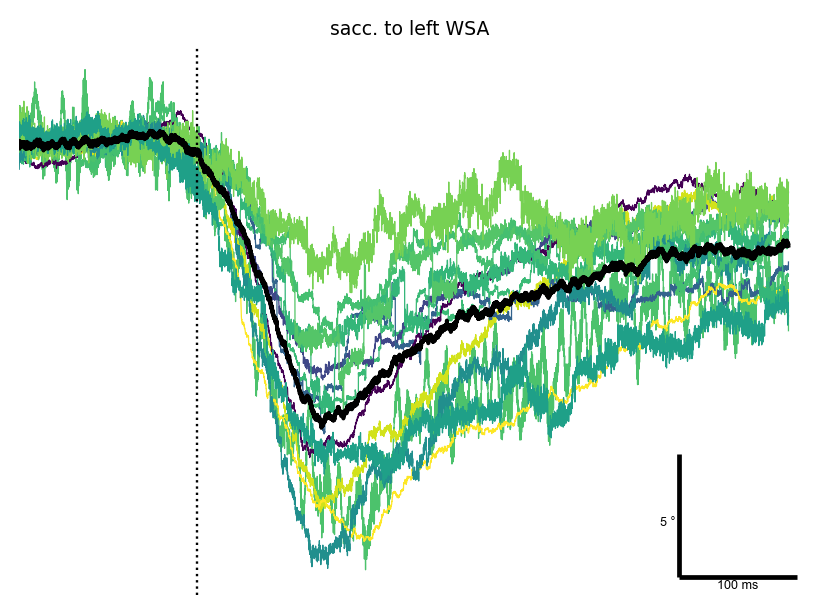

In [33]:
assert(all([list(polAmp_dict.keys())[i]==plotlist[i] for i in range(len(plotlist))])) #make sure order is correct
polAmp = np.array([val for _,val in polAmp_dict.items()])
plotcolors = plt.cm.viridis((polAmp-min(polAmp))/(max(polAmp)-min(polAmp)))
preOnset = 0.15#s , fixed during saccade detection routine (bould could be set differently any time by reassigning saccLeftMeanWBA etc)
samplingRate = 10000. # or set to da.samplingRate

f,ax=plt.subplots(1,1)
for i,k in enumerate(plotlist):
    ax.plot(np.arange(allSaccLeftMeanWBA[k].size)/samplingRate-preOnset, allSaccLeftMeanWBA[k],
            color=plotcolors[i], linewidth=0.8)
ax.set_title('sacc. to left WSA')
ax.set_ylabel('$\Delta$ WSA [°]')
ax.set_xlabel('time from onset [s]')
ax.axvline(0, linestyle=':', color='k')
ax.set_xlim([-preOnset,0.51])

# add a line for average
# pad to longest to make dimensions match
padLen = max([v.size  for k,v in allSaccLeftMeanWBA.items()])
allTraces = np.array([np.pad(v,(0,padLen-v.size), 'constant', constant_values=np.nan) for _,v in allSaccLeftMeanWBA.items()])
ax.plot(np.arange(padLen)/10000.-0.15, np.nanmean(allTraces,axis=0), 'k-', linewidth=2.5)

add_scalebar(ax, matchx=False, sizex=0.1, labelx='100 ms', matchy=False, sizey=5., labely='5 °', barwidth=3)
plt.tight_layout()

## Fig 2D
membrane potential corresponding to traces in Fig 2C

<IPython.core.display.Javascript object>


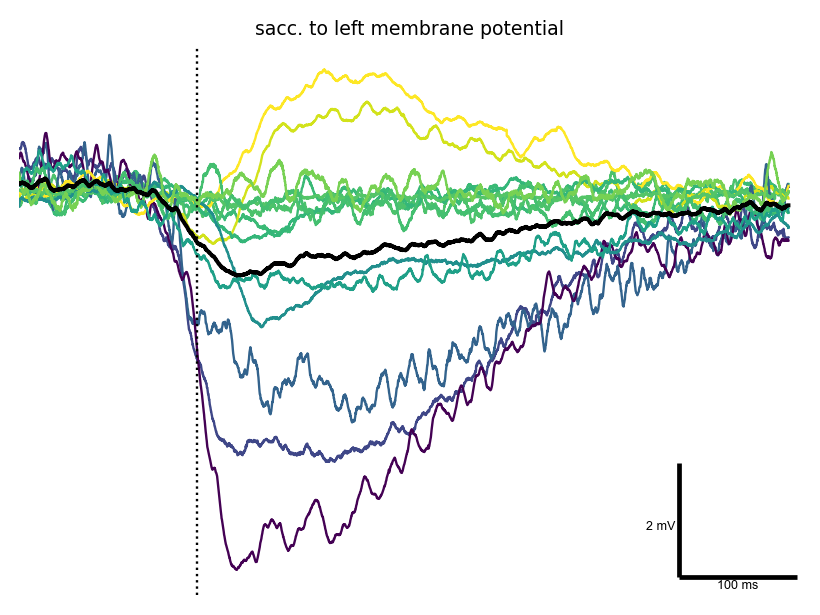

In [34]:
assert(all([list(polAmp_dict.keys())[i]==plotlist[i] for i in range(len(plotlist))])) #make sure order is correct
polAmp = np.array([val for _,val in polAmp_dict.items()])
plotcolors = plt.cm.viridis((polAmp-min(polAmp))/(max(polAmp)-min(polAmp)))
preOnset = 0.15#s , fixed during saccade detection routine (bould could be set differently any time by reassigning saccLeftMeanEphys etc)
samplingRate = 10000. # or set to da.samplingRate

f,ax=plt.subplots(1,1)
for i,k in enumerate(plotlist):
    ax.plot(np.arange(allSaccLeftMeanEphys[k].size)/samplingRate-preOnset, allSaccLeftMeanEphys[k]*100.,
            color=plotcolors[i], linewidth=1.5)
ax.set_title('sacc. to left membrane potential')
ax.set_ylabel('membrane potential [mV]')
ax.set_xlabel('time from onset [s]')
ax.axvline(0, linestyle=':', color='k')
ax.set_xlim([-preOnset,0.51])

# add a line for average
# pad to longest to make dimensions match
padLen = max([v.size  for k,v in allSaccLeftMeanEphys.items()])
allTraces = np.array([np.pad(v,(0,padLen-v.size), 'constant', constant_values=np.nan) for _,v in allSaccLeftMeanEphys.items()])
ax.plot(np.arange(padLen)/10000.-0.15, np.nanmean(allTraces,axis=0)*100., 'k-', linewidth=2.5)

add_scalebar(ax, matchx=False, sizex=0.1, labelx='100 ms', matchy=False, sizey=2., labely='2 mV', barwidth=3)
plt.tight_layout()

## Fig 2E

In [35]:
saSacc = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_HyPol__CWTdetection_saccading.neomat'))
saSacc.average_flywise()

saStrg = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                                 'Collections_saccade_straight', 
                                 'saccLeft_HyPol__CWTdetection_straight.neomat'))
saStrg.average_flywise()

<IPython.core.display.Javascript object>


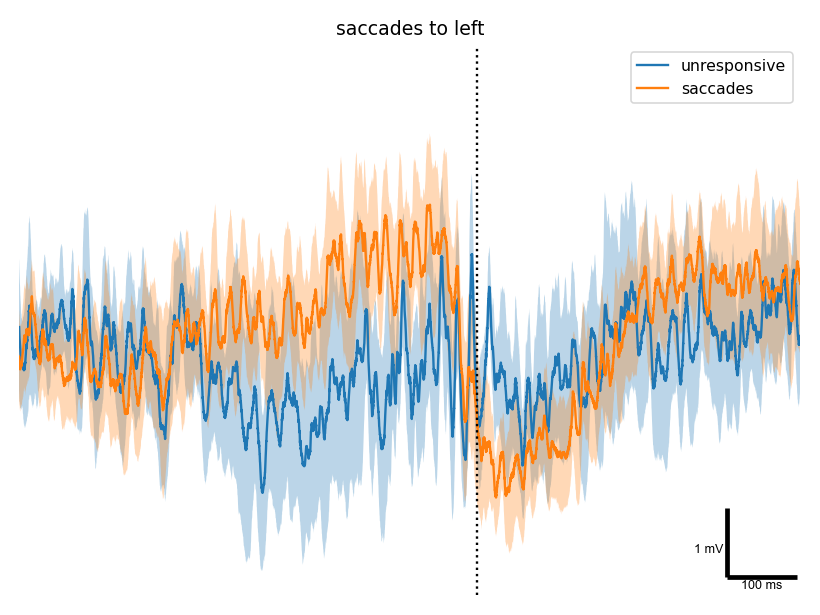

In [36]:
# prettier, clean plotting, membrane potential

# assert that we have equal datasets
strgSet = set([v.lower() for _,v in saStrg.flyID.items()])
saccSet = set([v.lower() for _,v in saSacc.flyID.items()])
assert(strgSet == saccSet)

f,ax=plt.subplots(1,1)
preSacc = 0.7 #s
postSacc = 0.5 #s
maxLoom = (saSacc.preStim+saSacc.stimulusPhases_inframes[1]*saSacc.meanFramePeriod)*saSacc.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc.samplingRate), int(maxLoom+postSacc*saSacc.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc.samplingRate-preSacc#-saSacc[i].preStim

d = saStrg.get_avg_data('ephys')
s = saStrg.get_std_data('ephys')
ax.plot(timeSlice, d[5][timeLims[0]:timeLims[1]]*100.)
ax.fill_between(timeSlice, 100.*(d[5]+s[5])[timeLims[0]:timeLims[1]], 100.*(d[5]-s[5])[timeLims[0]:timeLims[1]], alpha=0.3)

d = saSacc.get_avg_data('ephys')
s = saSacc.get_std_data('ephys')
ax.plot(timeSlice, d[5][timeLims[0]:timeLims[1]]*100.)
ax.fill_between(timeSlice, 100.*(d[5]+s[5])[timeLims[0]:timeLims[1]], 100.*(d[5]-s[5])[timeLims[0]:timeLims[1]], alpha=0.3)

ax.set_title('saccades to left')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.set_xlim([-preSacc, postSacc])
ax.axvline(0, linestyle=':', color='k')
ax.legend(['unresponsive','saccades'])

ax.set_xlim(PLOT_TIMEWINDOW)
ax.set_ylim([-3.5,4.5])
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=1., labely='1 mV', barwidth=3)
plt.tight_layout()

## Fig 2F

In [37]:
saSacc = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_NoPol__CWTdetection_saccading.neomat'))
saSacc.average_flywise()

saStrg = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 'Collections_saccade_straight', 
                                 'saccLeft_NoPol__CWTdetection_straight.neomat'))
saStrg.average_flywise()

<IPython.core.display.Javascript object>


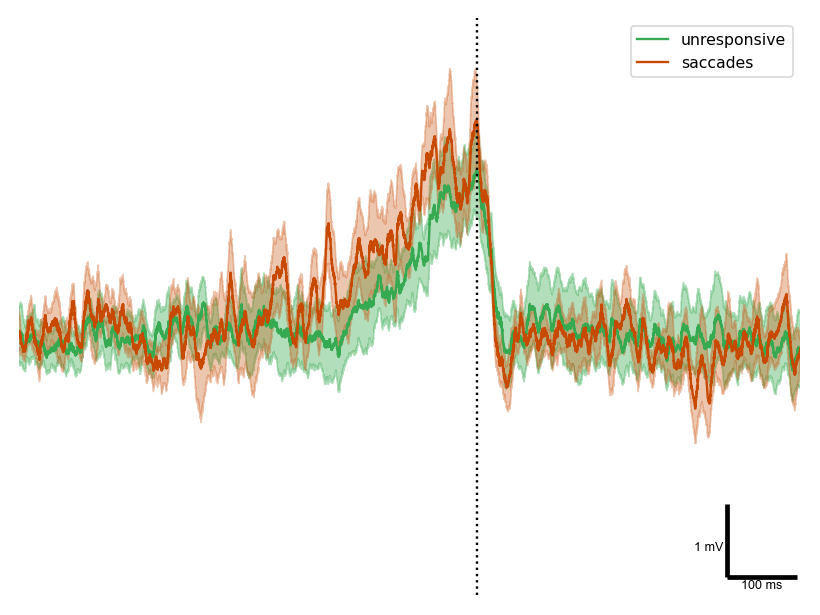

In [39]:
# membrane potential, multiply by factor of 100 to convert amplifier output to mV

# assert that we have equal datasets
strgSet = set([v for _,v in saStrg.flyID.items()])
saccSet = set([v for _,v in saSacc.flyID.items()])
assert(strgSet == saccSet)

f,ax=plt.subplots(1,1)
preSacc = 0.7 #s
postSacc = 0.5 #s
maxLoom = (saSacc.preStim+saSacc.stimulusPhases_inframes[1]*saSacc.meanFramePeriod)*saSacc.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc.samplingRate), int(maxLoom+postSacc*saSacc.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc.samplingRate-preSacc

d = saStrg.get_avg_data('ephys')
s = saStrg.get_std_data('ephys')
ax.plot(timeSlice, d[5][timeLims[0]:timeLims[1]]*100., color=plotColors[1])
ax.fill_between(timeSlice, 100.*(d[5]+s[5])[timeLims[0]:timeLims[1]], 100.*(d[5]-s[5])[timeLims[0]:timeLims[1]], 
               color=plotColors[1], alpha=plotAlphas[1])

d = saSacc.get_avg_data('ephys')
s = saSacc.get_std_data('ephys')
ax.plot(timeSlice, d[5][timeLims[0]:timeLims[1]]*100., color=plotColors[2])
ax.fill_between(timeSlice, 100.*(d[5]+s[5])[timeLims[0]:timeLims[1]], 100.*(d[5]-s[5])[timeLims[0]:timeLims[1]], 
               color=plotColors[2], alpha=plotAlphas[2])

# ax.set_title('saccades to left')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.axvline(0, linestyle=':', color='k')
ax.legend(['unresponsive','saccades'])

ax.set_xlim(PLOT_TIMEWINDOW)
# f.set_size_inches(85/25.4, 50/25.4)
ax.set_ylim([-3.5,4.5])
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=1., labely='1 mV', barwidth=3)
plt.tight_layout()

## Fig 2G
Plotting membrane potential during spontaneous and escape saccades side-by-side for the hyperpolarizing group

In [41]:
anlyz = []
flist= os.listdir(os.path.join(DATAPATH,'spontaneousSaccades','CWTdetection'))
#this simplifies in other folder structures
for fly in saccLeft_HyPol:
    #print(fly)
    fn = fly[0]
    if 'vonBettina' in fn:
        date = fn.split('/')[1][:8]
        date = date[-4:]+date[2:4]+date[:2]
    else:
        date = ''.join(fn.split('_'))
    name = '_'.join(fly[1].lower().split('_')[:2])
    name = name+'_'+date
    print(name)
    fl = [f for f in flist if name in f]
    fl = [f for f in fl if f.endswith('.neomat')]
    assert(len(fl)==1)
    a = DummyAnalyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 'spontaneousSaccades','CWTdetection', fl[0]))
    a.group_indices[a.group_indices!=0]=0
    helperLibrary.resampleAnalyzer(a) #wills kip if sampling rate is already 10kHz
    anlyz.append(a)


fly1_wtcs_20180725
fly1_u29xg06_20190213
fly1_wtcs_20190726
fly3_u29xg16_20200129
fly1_x20a_20200316
fly4_x21_20200420


In [45]:
def extract_saccade_LR_ephys_WBA(anlyz, **kwargs):
    allLeftEphys = []
    allLeftWBA = []
    allRightEphys = []
    allRightWBA = []
    preOnset_t = kwargs.get('preOnset',0.15)
    postOnset_t = kwargs.get('afterOnset',0.5)

    for el in range(len(anlyz)):
        if not isinstance(anlyz.saccades[el]['peakTime'], (list,np.ndarray)):
            anlyz.saccades[el] = {k:np.array([v]) for k,v in anlyz.saccades[el].items()}
        if len(anlyz.saccades[el]['peakTime'])==0:  continue
        v = anlyz.saccades[el]
        actualOnset= (v['CWTpeaks']*0.02*anlyz.samplingRate).astype(int)
        saccAmp = v['saccAmp']
        rightSaccEphys = []
        leftSaccEphys=[]
        leftSaccWBA=[]
        rightSaccWBA=[]
        chunk = int(postOnset_t*anlyz.samplingRate)
        preOnset = int(preOnset_t*anlyz.samplingRate)
        ephys = anlyz.segments[el].data[0]*100.#ephys data
        wba = anlyz.segments[el].data[-1]
        # CONVERT
        wba = wba*180./np.pi
        for j in range(saccAmp.size):
            o=actualOnset[j]
            a=saccAmp[j]
            p= (v['peakTime']*0.02*anlyz.samplingRate).astype(int)[j]
            if a<0:
                leftSaccEphys.append(ephys[o-preOnset:o+chunk])
                leftSaccWBA.append(wba[o-preOnset:o+chunk])
                d = wba[o-preOnset:o+chunk]
                xval = np.arange(-preOnset, d.size-preOnset)/anlyz.samplingRate
                d = ephys[o-preOnset:o+chunk]
            else:
                rightSaccEphys.append(ephys[o-preOnset:o+chunk])
                rightSaccWBA.append(wba[o-preOnset:o+chunk])
                d = wba[o-preOnset:o+chunk]
                xval = np.arange(-preOnset,d.size-preOnset)/anlyz.samplingRate
                d = ephys[o-preOnset:o+chunk]
        allLeftEphys.extend(leftSaccEphys)
        allLeftWBA.extend(leftSaccWBA)
        allRightEphys.extend(rightSaccEphys)
        allRightWBA.extend(rightSaccWBA)
    return allLeftEphys, allLeftWBA, allRightEphys, allRightWBA

<IPython.core.display.Javascript object>


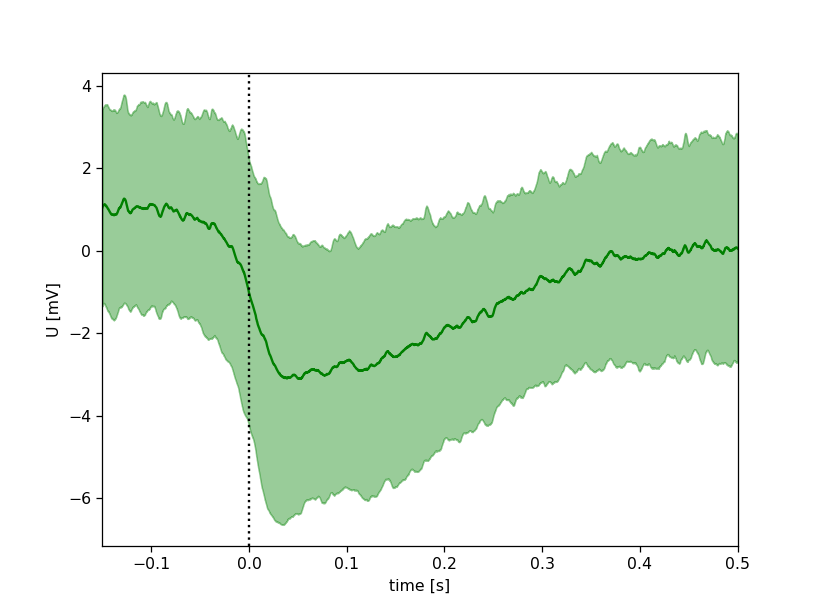

In [46]:
# AVERAGE OVER SACCADES AND STD
allLeftEphys = []
allLeftWBA = []
preOnset = 0.15#s
for a in anlyz:
    leftEphys,leftWBA,_,_ = extract_saccade_LR_ephys_WBA(a, preOnset=preOnset)
    allLeftEphys.extend(leftEphys)
    allLeftWBA.extend(leftWBA)

f,ax=plt.subplots(1,1)
maxLen = int(np.max([len(y) for y in allLeftEphys]))
xval = np.arange(maxLen)/anlyz[0].samplingRate-preOnset
m = np.nanmean(np.array([np.pad(y,(0,maxLen-len(y)), mode='constant', constant_values=np.nan) for y in allLeftEphys]), axis=0)
s = np.nanstd(np.array([np.pad(y,(0,maxLen-len(y)), mode='constant', constant_values=np.nan) for y in allLeftEphys]), axis=0)
# s /= np.sqrt(len(anlyz))
ax.plot(xval, m, color='g')
ax.fill_between(xval, m+s,m-s, color='g', alpha=0.4)
# ax.set_title('spontaneous saccades to left')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.set_xlim([-preOnset, 0.5])
ax.axvline(0, linestyle=':', color='k')
# plt.tight_layout()

<IPython.core.display.Javascript object>


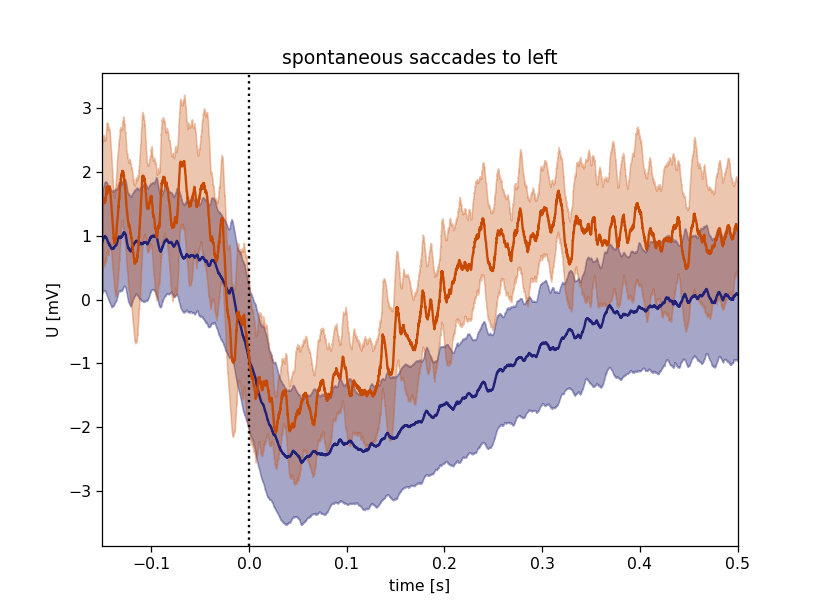

In [47]:
# AVERAGE SACCADE, average flywise and proper s.e.m
# ephys
allLeftEphys = []
allLeftEphys_std = []
preOnset = 0.15#s
for a in anlyz:
    leftEphys,leftWBA,_,_ = extract_saccade_LR_ephys_WBA(a, preOnset=preOnset)
    maxLen = max([len(y) for y in leftEphys])
    meanLeftEphys = np.nanmean(np.array([np.pad(y,(0,maxLen-len(y)), mode='constant', constant_values=np.nan)
                         for y in leftEphys]), axis=0)
    stdLeftEphys = np.nanstd(np.array([np.pad(y,(0,maxLen-len(y)), mode='constant', constant_values=np.nan)
                         for y in leftEphys]), axis=0)
    allLeftEphys.append(meanLeftEphys)
    allLeftEphys_std.append(stdLeftEphys)

f,ax=plt.subplots(1,1)
maxLen = int(np.max([len(y) for y in allLeftEphys]))
xval = np.arange(maxLen)/anlyz[0].samplingRate-preOnset
m = np.nanmean(np.array([np.pad(y,(0,maxLen-len(y)), mode='constant', constant_values=np.nan) for y in allLeftEphys]), axis=0)
s = np.sqrt(np.sum(np.array([np.pad(y,(0,maxLen-len(y)), mode='constant', constant_values=np.nan)**2. 
                           for y in allLeftEphys_std]),axis=0) / len(anlyz)**2)

ax.plot(xval, m, color='#212178')
ax.fill_between(xval, m+s,m-s, color='#212178', alpha=0.4)
ax.set_title('spontaneous saccades to left')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.set_xlim([-preOnset, 0.5])
ax.axvline(0, linestyle=':', color='k')

In [49]:
saSacc = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_HyPol__CWTdetection_saccading.neomat'))
saSacc.flyID

{0: 'fly1_WTCS_20180725_cell1',
 1: 'fly4_X21_20200420_cell1',
 2: 'fly1_U29xG06_20190213_cell1',
 3: 'fly1_WTCS_20190726_cell1',
 4: 'fly3_U29xG16_20200129_cell1',
 5: 'fly1_X20a_20200316_cell1'}

In [50]:
# saSacc.average_by_stimSignal()
saSacc.average_flywise()

In [51]:
preSacc = 0.2 #s
postSacc = 0.5 #s
maxLoom = (saSacc.preStim+saSacc.stimulusPhases_inframes[1]*saSacc.meanFramePeriod)*saSacc.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc.samplingRate), int(maxLoom+postSacc*saSacc.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc.samplingRate-preSacc#-saSacc[i].preStim

d = saSacc.get_avg_data('ephys')
s = saSacc.get_std_data('ephys')
ax.plot(timeSlice, d[5][timeLims[0]:timeLims[1]]*100., color=plotColors[2], linewidth=1.5)
ax.fill_between(timeSlice, 100.*(d[5]+s[5])[timeLims[0]:timeLims[1]], 100.*(d[5]-s[5])[timeLims[0]:timeLims[1]],
                color=plotColors[2], alpha=plotAlphas[2])


In [108]:
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=1., labely='1 mV', barwidth=3)

# Figure 3
## load data

In [7]:
flist = glob.glob(os.path.join(DATAPATH,'spontaneousSaccades','oldData','CWTdetection','*.neomat'))
flist

['F:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20111222_cell1_oldData_spontSaccades_cwtDetection.neomat',
 'F:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120104_cell1_oldData_spontSaccades_cwtDetection.neomat',
 'F:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120104_cell2_oldData_spontSaccades_cwtDetection.neomat',
 'F:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120105_cell1_oldData_spontSaccades_cwtDetection.neomat',
 'F:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120105_cell2_oldData_spontSaccades_cwtDetection.neomat',
 'F:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120207_cell1_oldData_spontSaccades_cwtDetection.neomat',
 'F:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120217_cell1_oldData_spontSaccades_cwtDetection.neomat',
 'F:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_

In [ ]:
allSaccLeftMeanEphys = {}
allSaccLeftMeanWBA = {}
allSaccRightMeanEphys = {}
allSaccRightMeanWBA = {}
onset = 0.15

for fn in flist[:]:
    da = DummyAnalyzer.retrieveFromNeomatfile(fn)
    if 'oldData' not in fn: # conversion from radian to degree for data recorded in this study
        print('multiplying WBA at',fn)
        da.saccLeftMeanWBA *= (180/np.pi)
        da.saccRightMeanWBA *= (180/np.pi)
    else: # old data is from a different rig, and needs another conversion factor to obtain degrees
        da.saccLeftMeanWBA /= 1.7
        da.saccRightMeanWBA /= 1.7
    if max(abs(da.saccLeftMeanEphys)) <0.1: #same idea, deal with different conversion factors
        print('multiplying Vm at',fn)
        da.saccLeftMeanEphys *= 100.
        da.saccRightMeanEphys *= 100.
    if abs(da.samplingRate -10000) >10:
        raise Exception('unexpected sampling rate')
    
    # gather part of data that matters for plots, i.e. 150ms before onset and the 500ms after
    allSaccLeftMeanEphys[da.flyID[0]] = da.saccLeftMeanEphys[-int((0.5+onset)*da.samplingRate):]
    allSaccRightMeanEphys[da.flyID[0]] = da.saccRightMeanEphys[-int((0.5+onset)*da.samplingRate):]
    allSaccLeftMeanWBA[da.flyID[0]] = da.saccLeftMeanWBA[-int((0.5+onset)*da.samplingRate):]
    allSaccRightMeanWBA[da.flyID[0]] = da.saccRightMeanWBA[-int((0.5+onset)*da.samplingRate):]

In [ ]:
subtype_dict = {'HSN': ('fly1_wtcs_20111222_cell1',
                        'fly1_wtcs_20120207_cell1',
                        'fly1_wtcs_20120504_cell1',
                        'fly1_wtcs_20120508_cell1',
                        'fly1_wtcs_20120418_cell2',
                        'fly1_wtcs_20130506_cell1',
                       ),
               'HSE': ('fly1_wtcs_20120104_cell1',
                       'fly1_wtcs_20120105_cell1',
                       'fly1_wtcs_20120501_cell1',
                       'fly1_wtcs_20120105_cell2',
                       'fly1_wtcs_20120524_cell2',
                       'fly1_wtcs_20130502_cell2',
                       'fly1_wtcs_20130513_cell1'),
               'HSS': ('fly1_wtcs_20120605_cell1',
                       'fly1_wtcs_20120104_cell2',
                       'fly1_wtcs_20130211_cell1',
                       'fly1_wtcs_20130424_cell1',
                       )
               }

## Fig 3B

In [ ]:
f,ax=plt.subplots(1,1, figsize=(7,5))

# BEGIN WITH HSE
plotlist = subtype_dict['HSE']
print('HSE')
plotcolors = plt.cm.YlGn(np.linspace(0.2,0.7,len(plotlist)))
for i,k in enumerate(plotlist):
    print(k)
    data = allSaccLeftMeanWBA[k]
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# add average line
minLen = min([allSaccLeftMeanWBA[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanWBA[fid][:minLen] for fid in plotlist])
avg_HSE = np.mean(alldata, axis=0)
std_HSE = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSE.size)/10000.-0.15,avg_HSE, color=plt.cm.YlGn(0.85), linewidth=2)

# THEN HSS
plotlist = subtype_dict['HSS']
print('HSS')
plotcolors = plt.cm.pink(np.linspace(0.3,0.4,len(plotlist)))
for i,k in enumerate(plotlist):
    print(k)
    data = allSaccLeftMeanWBA[k]
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# add average line
minLen = min([allSaccLeftMeanWBA[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanWBA[fid][:minLen] for fid in plotlist])
avg_HSS = np.mean(alldata, axis=0)
std_HSS = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSS.size)/10000.-0.15,avg_HSS, color=plt.cm.Purples(0.98), linewidth=2)

# LAST COME HSN
plotlist = subtype_dict['HSN']
print('HSN')
plotcolors = plt.cm.Purples(np.linspace(0.2,0.7,len(plotlist)))
for i,k in enumerate(plotlist):
    print(k)
    data = allSaccLeftMeanWBA[k]
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# add average line
minLen = min([allSaccLeftMeanWBA[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanWBA[fid][:minLen] for fid in plotlist])
avg_HSN = np.mean(alldata, axis=0)
std_HSN = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSN.size)/10000.-0.15,avg_HSN, color=plt.cm.Purples(0.98), linewidth=2)

# FINALLY ALL AVERAGE LINES
ax.plot(np.arange(avg_HSS.size)/10000.-0.15,avg_HSS, color=plt.cm.pink(0.2), linewidth=3, label='mean HSS')
ax.plot(np.arange(avg_HSE.size)/10000.-0.15,avg_HSE, color=plt.cm.YlGn(0.85), linewidth=3, label='mean HSE')
ax.plot(np.arange(avg_HSN.size)/10000.-0.15,avg_HSN, color=plt.cm.Purples(0.98), linewidth=3, label='mean HSN')
# ax.legend()

# sugar
ax.axvline(0, linestyle='--', color='k')
ax.set_xlim([-0.15,0.48])
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False,
             sizey=5.0, labely='5°', barwidth=3)
plt.tight_layout()

## Fig 3C
This is essentially the same plot as in Fig S2B, only replacing the L-R WBA with ephys

In [ ]:
f,ax=plt.subplots(1,1, figsize=(7,5))

# BEGIN WITH HSE
plotlist = subtype_dict['HSE']
print('HSE')
plotcolors = plt.cm.YlGn(np.linspace(0.2,0.7,len(plotlist)))
for i,k in enumerate(plotlist):
    print(k)
    data = allSaccLeftMeanEphys[k]
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# add average line
minLen = min([allSaccLeftMeanEphys[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanEphys[fid][:minLen] for fid in plotlist])
avg_HSE = np.mean(alldata, axis=0)
std_HSE = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSE.size)/10000.-0.15,avg_HSE, color=plt.cm.YlGn(0.85), linewidth=2)


# THEN HSS
plotlist = subtype_dict['HSS']
print('HSS')
plotcolors = plt.cm.pink(np.linspace(0.3,0.4,len(plotlist)))
for i,k in enumerate(plotlist):
    print(k)
    data = allSaccLeftMeanEphys[k]
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# add average line
minLen = min([allSaccLeftMeanEphys[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanEphys[fid][:minLen] for fid in plotlist])
avg_HSS = np.mean(alldata, axis=0)
std_HSS = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSS.size)/10000.-0.15,avg_HSS, color=plt.cm.Purples(0.98), linewidth=2)

# LAST HSN
plotlist = subtype_dict['HSN']
print('HSN')
plotcolors = plt.cm.Purples(np.linspace(0.2,0.7,len(plotlist)))
for i,k in enumerate(plotlist):
    print(k)
    data = allSaccLeftMeanEphys[k]
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# add average line
minLen = min([allSaccLeftMeanEphys[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanEphys[fid][:minLen] for fid in plotlist])
avg_HSN = np.mean(alldata, axis=0)
std_HSN = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSN.size)/10000.-0.15,avg_HSN, color=plt.cm.Purples(0.98), linewidth=2)

# ADD AVERAGE LINES (plotted here so they end up on top)
ax.plot(np.arange(avg_HSS.size)/10000.-0.15,avg_HSS, color=plt.cm.pink(0.2), linewidth=3, label='mean HSS')
ax.plot(np.arange(avg_HSE.size)/10000.-0.15,avg_HSE, color=plt.cm.YlGn(0.85), linewidth=3, label='mean HSE')
ax.plot(np.arange(avg_HSN.size)/10000.-0.15,avg_HSN, color=plt.cm.Purples(0.99), linewidth=3, label='mean HSN')
# ax.legend()

# some sugar
ax.axvline(0, linestyle='--', color='k')
ax.set_xlim([-0.15,0.48])
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False,
             sizey=1.0, labely='1 mV', barwidth=3)
plt.tight_layout()

## Fig 3D

In [ ]:
# extract maximal L-R WBA and membrane potential amplitudes in a 200ms window after saccade onset put in dict structure
# refer to previosu cell to avoid mistakes
polAmp_dict={}
saccAmp_dict={}
onset=0.15 #150ms into datapiece, because of way we loaded data at beginning of Figure S2

for flyid in allSaccRightMeanEphys.keys():
    d=allSaccLeftMeanEphys[flyid]
    d = ndimage.gaussian_filter1d(d, 60)
    ix = int(np.argmax(signal.medfilt(np.abs(d[int(onset*10000):int((onset+0.2)*10000)]), 101))+0.15*10000)
    polAmp_dict[flyid] = d[ix]

    d=allSaccLeftMeanWBA[flyid]
    d = ndimage.gaussian_filter1d(d, 60)
    ix = int(np.argmax(signal.medfilt(np.abs(d[int(onset*10000):int((onset+0.2)*10000)]), 101))+0.15*10000)
    saccAmp_dict[flyid] = d[ix]


In [ ]:
#statisticType = 'median-quartile'
statisticType = 'mean-sd'

In [ ]:
f,ax=plt.subplots(1,1, figsize=(5,4))

#HSE
plotlist = subtype_dict['HSE']
# remove the problematic one(s)
# plotlist = [flyid for flyid in subtype_dict['HSE'] if not flyid in behavioral_outliers]
plotcolors = plt.cm.YlGn(np.linspace(0.2,0.7,len(plotlist)))
i=0
print('HSE')
for i,flyid in enumerate(plotlist):
    print(flyid)
    ax.scatter(saccAmp_dict[flyid], polAmp_dict[flyid], color=plotcolors[i], marker='o')
    i+=1
# calculate average dot
if statisticType=='mean-sd':
    avg_HSE_wba = np.mean( [saccAmp_dict[flyid] for flyid in plotlist])
    avg_HSE_ephys = np.mean( [polAmp_dict[flyid] for flyid in plotlist])
    dev_HSE_wba = np.std( [saccAmp_dict[flyid] for flyid in plotlist])
    dev_HSE_ephys = np.std( [polAmp_dict[flyid] for flyid in plotlist])
elif statisticType=='median-quartile':# median and quartile
    avg_HSE_wba = np.median( [saccAmp_dict[flyid] for flyid in plotlist])
    avg_HSE_ephys = np.median( [polAmp_dict[flyid] for flyid in plotlist])
    dev_HSE_wba = np.quantile( [saccAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])
    dev_HSE_ephys = np.quantile( [polAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])
else:
    raise Exception('unexpected key word for statisticType')

# HSS
plotlist = subtype_dict['HSS']
# plotlist = [flyid for flyid in subtype_dict['HSS'] if not flyid in behavioral_outliers]
plotcolors = plt.cm.pink(np.linspace(0.3,0.4,len(plotlist)))
i=0
print('HSS')
for i,flyid in enumerate(plotlist):
    print(flyid)
    ax.plot(saccAmp_dict[flyid], polAmp_dict[flyid], color=plotcolors[i], marker='o')
    i+=1
if statisticType=='mean-sd':
    avg_HSS_wba = np.mean( [saccAmp_dict[flyid] for flyid in plotlist])
    avg_HSS_ephys = np.mean( [polAmp_dict[flyid] for flyid in plotlist])
    dev_HSS_wba = np.std( [saccAmp_dict[flyid] for flyid in plotlist])
    dev_HSS_ephys = np.std( [polAmp_dict[flyid] for flyid in plotlist])
elif statisticType=='median-quartile':# median and quartile
    avg_HSS_wba = np.median( [saccAmp_dict[flyid] for flyid in plotlist])
    avg_HSS_ephys = np.median( [polAmp_dict[flyid] for flyid in plotlist])
    dev_HSS_wba = np.quantile( [saccAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])
    dev_HSS_ephys = np.quantile( [polAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])
else:
    raise Exception('unexpected key word for statisticType')

# HSN
plotlist = subtype_dict['HSN']
# plotlist = [flyid for flyid in subtype_dict['HSN'] if not flyid in behavioral_outliers]
plotcolors = plt.cm.Purples(np.linspace(0.2,0.7,len(plotlist)))
i=0
print('HSN')
for i,flyid in enumerate(plotlist):
    print(flyid)
    ax.plot(saccAmp_dict[flyid], polAmp_dict[flyid], color=plotcolors[i], marker='o')
    i+=1
if statisticType=='mean-sd':
    avg_HSN_wba = np.mean( [saccAmp_dict[flyid] for flyid in plotlist])
    avg_HSN_ephys = np.mean( [polAmp_dict[flyid] for flyid in plotlist])
    dev_HSN_wba = np.std( [saccAmp_dict[flyid] for flyid in plotlist])
    dev_HSN_ephys = np.std( [polAmp_dict[flyid] for flyid in plotlist])
elif statisticType=='median-quartile':# median and quartile
    avg_HSN_wba = np.median( [saccAmp_dict[flyid] for flyid in plotlist])
    avg_HSN_ephys = np.median( [polAmp_dict[flyid] for flyid in plotlist])
    dev_HSN_wba = np.quantile( [saccAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])
    dev_HSN_ephys = np.quantile( [polAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])
else:
    raise Exception('unexpected key word for statisticType')

#sugar
ax.set_xlabel('mean saccade amplitude [°]')
ax.set_ylabel('mean saccade-associated potential [mV]')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(range(-22,-9,4))
ax.set_yticks(range(-2,5,2))
plt.tight_layout()


# add average dots
ax.plot(avg_HSE_wba, avg_HSE_ephys, color=plt.cm.YlGn(0.85),
        marker='s',markersize=10,markeredgecolor='k',linewidth=2)
ax.plot(avg_HSS_wba, avg_HSS_ephys, color=plt.cm.pink(0.2),
        marker='s',markersize=10,markeredgecolor='k',linewidth=2)
ax.plot(avg_HSN_wba, avg_HSN_ephys, color=plt.cm.Purples(0.98),
        marker='s',markersize=10,markeredgecolor='k',linewidth=2)


# plotting mean +- sd
ax.errorbar(avg_HSE_wba, avg_HSE_ephys, xerr=dev_HSE_wba, yerr=dev_HSE_ephys, color=plt.cm.YlGn(0.85),
        marker='s',markersize=10,markeredgecolor='k',linewidth=3)
ax.errorbar(avg_HSS_wba, avg_HSS_ephys, xerr=dev_HSS_wba, yerr=dev_HSS_ephys, color=plt.cm.pink(0.2),
        marker='s',markersize=10,markeredgecolor='k',linewidth=3)
ax.errorbar(avg_HSN_wba, avg_HSN_ephys, xerr=dev_HSN_wba, yerr=dev_HSN_ephys, color=plt.cm.Purples(0.98),
        marker='s',markersize=10,markeredgecolor='k',linewidth=3)

### statistical test(s) on amplitudes
Testing for difference between HSN <-> HSS, and HSN <-> HSE

Considering the sizes of the subpopulations and that they are apparently not normally distributed, it's better to use the Mann-Whitney-U (non-parametric) test.

The bracket and stars have been added using Inkscape.

In [ ]:
###### ephys ######
hse_vals = [polAmp_dict[flyid] for flyid in subtype_dict['HSE']]
hsn_vals = [polAmp_dict[flyid] for flyid in subtype_dict['HSN']]
hss_vals = [polAmp_dict[flyid] for flyid in subtype_dict['HSS']]

print('HSN vs HSS', stats.mannwhitneyu(hsn_vals, hss_vals, method='exact'))
print('HSN vs HSE', stats.mannwhitneyu(hsn_vals, hse_vals, method='exact'))
#print('HSS vs HSE', stats.mannwhitneyu(hse_vals, hss_vals, method='exact'))

# Figure 4
## load data for panels A&B

In [52]:
# load new subsets
saSacc_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_saccading.neomat'))
saStrg_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_straight.neomat'))
saSacc_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__CWTdetection_saccading.neomat'))
saStrg_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__CWTdetection_straight.neomat'))
helperLibrary.resampleAnalyzer(saSacc_Rhyp)
helperLibrary.resampleAnalyzer(saStrg_Rhyp)
helperLibrary.resampleAnalyzer(saSacc_Rnop)
helperLibrary.resampleAnalyzer(saStrg_Rnop)

saStrg_Rhyp.clean_flyIDs()
saStrg_Rhyp.reallocate_fly_indices()
saStrg_Rnop.clean_flyIDs()
saStrg_Rnop.reallocate_fly_indices()

saSacc_Rhyp.clean_flyIDs()
saSacc_Rhyp.reallocate_fly_indices()
saSacc_Rnop.clean_flyIDs()
saSacc_Rnop.reallocate_fly_indices()

In [9]:
saSacc_all = copy.copy(saSacc_Rhyp)
saStrg_all = copy.copy(saStrg_Rhyp)
#saFly = copy.copy(saFly_Rhyp)
#saRest = copy.copy(saRest_Rhyp)

saSacc_all = saSacc_all + saSacc_Rnop
saStrg_all = saStrg_all + saStrg_Rnop
#saFly = saFly + saFly_Rnop
#saRest = saRest + saRest_Rnop

In [10]:
saSacc_all.baseline_correct_data(baseline_startpoint=int((saSacc_all.preStim+0.15)*saSacc_all.samplingRate))
saStrg_all.baseline_correct_data(baseline_startpoint=int((saStrg_all.preStim+0.15)*saStrg_all.samplingRate))
saSacc_all.average_by_stimSignal()
saStrg_all.average_by_stimSignal()

## Fig 4A

<IPython.core.display.Javascript object>


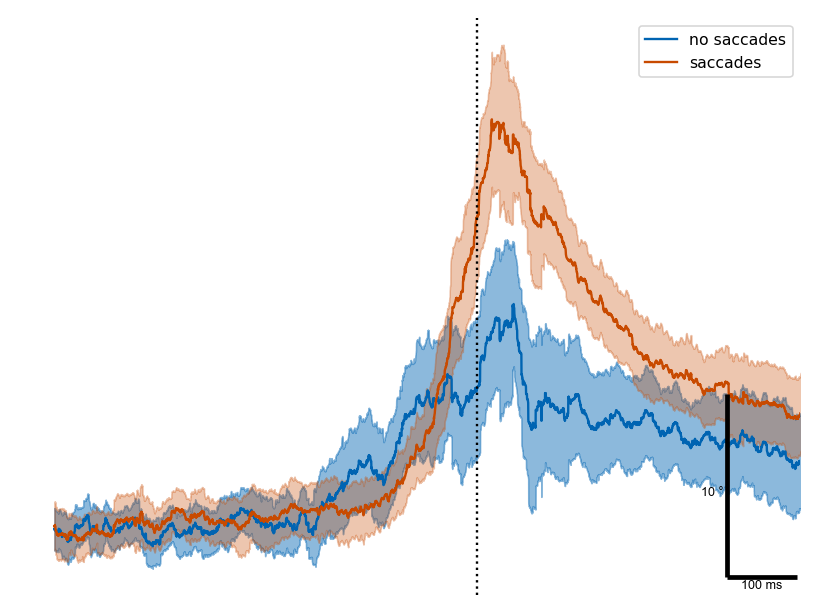

In [11]:
# prettier, clean plotting, membrane potential

# assert that we have equal datasets
strgSet = set([v.lower() for _,v in saStrg_all.flyID.items()])
# restSet = set([v.lower() for _,v in saRest.flyID.items()])
saccSet = set([v.lower() for _,v in saSacc_all.flyID.items()])

''' MASSIVE NO-GO FOR NOW; BECAUSE I NEED TO FIX THE FLYID THING'''
#assert(strgSet == restSet)
#assert(saccSet == restSet)

f,ax=plt.subplots(1,1)
preSacc = 0.6 #s
postSacc = 0.5 #s
maxLoom = (saSacc_all.preStim+saSacc_all.stimulusPhases_inframes[1]*saSacc_all.meanFramePeriod)*saSacc_all.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc_all.samplingRate), int(maxLoom+postSacc*saSacc_all.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc_all.samplingRate-preSacc#-saSacc_all[i].preStim

# d = saRest.get_avg_data('wingDiff')
# s = saRest.get_std_data('wingDiff')
# ax.plot(timeSlice, d[2][timeLims[0]:timeLims[1]]*180./np.pi, color=plotColors[0])
# ax.fill_between(timeSlice, 180./np.pi*(d[2]+s[2])[timeLims[0]:timeLims[1]], 180./np.pi*(d[2]-s[2])[timeLims[0]:timeLims[1]],
#                color=plotColors[0], alpha=plotAlphas[0])

d = saStrg_all.get_avg_data('wingDiff')
s = saStrg_all.get_std_data('wingDiff')
ax.plot(timeSlice, d[2][timeLims[0]:timeLims[1]]*180./np.pi, color=plotColors[0])
ax.fill_between(timeSlice, 180./np.pi*(d[2]+s[2])[timeLims[0]:timeLims[1]], 180./np.pi*(d[2]-s[2])[timeLims[0]:timeLims[1]],
               color=plotColors[0], alpha=plotAlphas[0])

d = saSacc_all.get_avg_data('wingDiff')
s = saSacc_all.get_std_data('wingDiff')
ax.plot(timeSlice, d[2][timeLims[0]:timeLims[1]]*180./np.pi, color=plotColors[2])
ax.fill_between(timeSlice, 180./np.pi*(d[2]+s[2])[timeLims[0]:timeLims[1]], 180./np.pi*(d[2]-s[2])[timeLims[0]:timeLims[1]],
               color=plotColors[2], alpha=plotAlphas[2])

#ax.set_title('saccades to right')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.set_xlim([-preSacc, postSacc])
ax.axvline(0, linestyle=':', color='k')
# ax.legend(['rest', 'no saccades','saccades'])
ax.legend(['no saccades','saccades'])

ax.set_xlim(PLOT_TIMEWINDOW)
#f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=10.0, labely='10 °', barwidth=3)
plt.tight_layout()



## Fig 4B

<IPython.core.display.Javascript object>


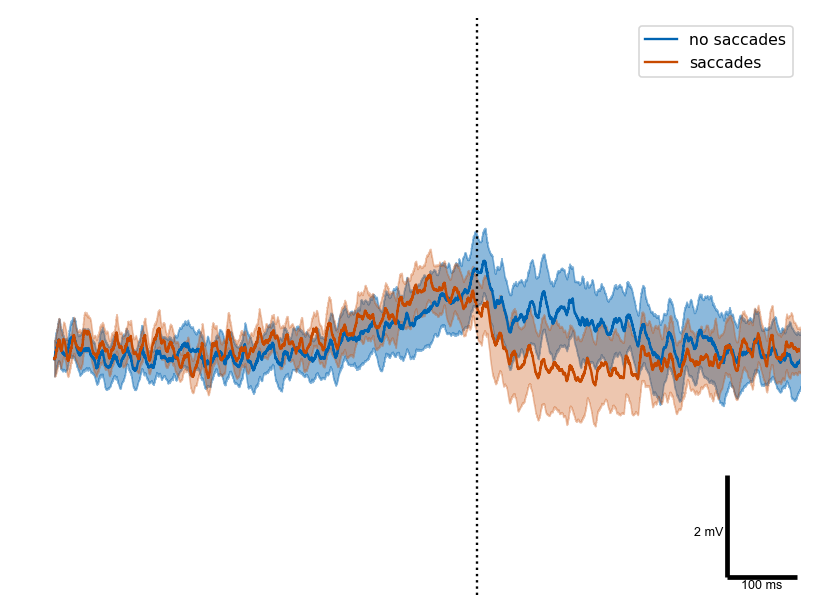

In [12]:
# membrane potential

# assert that we have equal datasets
strgSet = set([v.lower() for _,v in saStrg_all.flyID.items()])
saccSet = set([v.lower() for _,v in saSacc_all.flyID.items()])

''' MASSIVE NO-GO FOR NOW; BECAUSE I NEED TO FIX THE FLYID THING'''
#assert(strgSet == restSet)
#assert(saccSet == restSet)

f,ax=plt.subplots(1,1)
preSacc = 0.6 #s
postSacc = 0.5 #s
maxLoom = (saSacc_all.preStim+saSacc_all.stimulusPhases_inframes[1]*saSacc_all.meanFramePeriod)*saSacc_all.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc_all.samplingRate), int(maxLoom+postSacc*saSacc_all.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc_all.samplingRate-preSacc#-saSacc_all[i].preStim

d = saStrg_all.get_avg_data('ephys')
s = saStrg_all.get_std_data('ephys')
ax.plot(timeSlice, d[2][timeLims[0]:timeLims[1]]*100., color=plotColors[0])
ax.fill_between(timeSlice, 100.*(d[2]+s[2])[timeLims[0]:timeLims[1]], 100.*(d[2]-s[2])[timeLims[0]:timeLims[1]],
               color=plotColors[0], alpha=plotAlphas[0])

d = saSacc_all.get_avg_data('ephys')
s = saSacc_all.get_std_data('ephys')
ax.plot(timeSlice, d[2][timeLims[0]:timeLims[1]]*100., color=plotColors[2])
ax.fill_between(timeSlice, 100.*(d[2]+s[2])[timeLims[0]:timeLims[1]], 100.*(d[2]-s[2])[timeLims[0]:timeLims[1]],
               color=plotColors[2], alpha=plotAlphas[2])

#ax.set_title('saccades to right')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.set_xlim([-preSacc, postSacc])
ax.axvline(0, linestyle=':', color='k')
ax.legend(['no saccades','saccades'])


ax.set_xlim(PLOT_TIMEWINDOW)
ax.set_ylim([-4.8,6.5]) #avgSEM
# ax.set_ylim([-6.,8.35]) #avgSTD-byStimSig
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=2.0, labely='2 mV', barwidth=3)
plt.tight_layout()



## Fig 4C
The left part of this panel is a purely artistic schematic drawing. The right part is data-derived, though.

In [14]:
allflies = saccLeft_HyPol[:]
allflies.extend(saccLeft_DePol)
allflies.extend(saccLeft_NoPol)

### Load all flies flying

In [106]:
# LOAD
saFly = []
for root,fly in allflies:
    a = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, root, f'{fly}looming_wb__flying.neomat'))
    helperLibrary.resampleAnalyzer(a)# only does something where necessary
    a.average_flywise()
    saFly.append(a)

In [ ]:
# other way, using collections (originally established only later), previous cell kept for demonstration
anlyz = [None, None]
anlyz[0] = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__flying.neomat'))
anlyz[1] = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__flying.neomat'))

saStrg_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile()
saSacc_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__CWTdetection_saccading.neomat'))

In [108]:
# LOAD
saRest = []
for root,fly in allflies:
    a = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, root, f'{fly}looming_wb__resting.neomat'))
    helperLibrary.resampleAnalyzer(a)# only does something where necessary
    a.average_flywise()
    saRest.append(a)

### calculate criterion

In [16]:
# extract a mean trace overa ll flies (without having to combine all datasets, which is tedious)
# -> not necessary, only for confirming other results
stimID = 2

loomLeft=[]
legEntry=[]
for a in saFly:
    d = a.get_avg_data('ephys')[stimID]*100.# conversion factor to mV
    d = ndimage.gaussian_filter1d(d,5)
    loomLeft.append(d)
    legEntry.append(a.flyID[0])
minLen = min([len(d) for d in loomLeft]) # cut to shortest instance (which still covers all the stimulus anyhow)
loomLeft = np.array([d[:minLen] for d in loomLeft])
time = a.timeax
meanFlight = np.mean(loomLeft,axis=0)

<IPython.core.display.Javascript object>


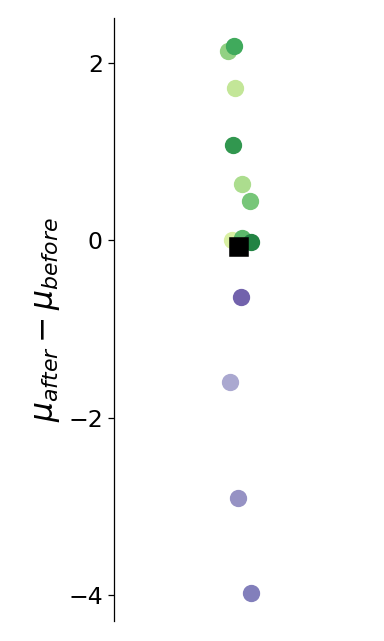

fly1_WTCS_20180725_cell1
fly1_WTCS_20190213_cell1
fly1_WTCS_20190726_cell1
fly3_U29xG16_20200129_cell1
fly1_X20a_20200316_cell1
fly4_X21_20200420_cell1
fly1_WTCS_20191106_cell1
fly1_U29xG16_20200129_cell1
fly1_G06xU29_20191104_cell1
fly1_U29xG16_20191209_cell2
fly3_X21_20200415_cell1
fly3_x21_20200417_cell1
fly2_X20_20210217_cell1


In [23]:
before = []
after = []
deltas = []
beforerange = np.arange(7000,8000) #stretch of data (indices) beofre maximum looming
afterrange = np.arange(11000,12000) #stretch of data (indices) after maximum looming

f,ax=plt.subplots(1,1, figsize=(3,5))
rng = np.random.default_rng() # for creating slight x-offset so points don't cover one another
for a in saFly:
    fid = a.flyID[0]
    print(fid)
    d = a.get_avg_data('ephys')[stimID]*100.
    d = ndimage.gaussian_filter1d(d,5)
    b = np.mean(d[beforerange])
    before.append(b)
    a = np.mean(d[afterrange])
    after.append(a)
    deltas.append(a-b)
    ax.plot(0+rng.uniform(low=-0.001,high=0.001), a-b,'o', markersize=10)

meanDelta = np.mean(deltas)
#stdDelta = np.std(deltas)
ax.plot(meanDelta, 'ks', markersize=11)
#ax.plot([0,0], [meanDelta-stdDelta, meanDelta+stdDelta], 'k-')

#prettify
ax.set_xlim([-0.01,0.01])

ax.set_ylabel('$\mu_{after}-\mu_{before}$', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticks([-4,-2,0,2])
plt.tight_layout()

In [24]:
# CHANGE COLORS AFTER KNOWING THE MEAN
# alternative way to retrieve diffs from plot
#diffs = np.array([ch.get_ydata()[0] for ch in ax[1].get_children() if isinstance(ch,plt.Line2D)]).flatten()

dots = [ch for ch in ax.get_children() if isinstance(ch, plt.Line2D)]

idxAboveMean = np.where(deltas>meanDelta)[0]
dotColors = plt.cm.YlGn(np.linspace(0.25,0.75,len(idxAboveMean)))
# dotColors = plt.cm.Blues(np.linspace(0.3,0.6,len(idxAboveMean)))
for ix,col in zip(idxAboveMean, dotColors):
    dots[ix].set_color(col)

idxBelowMean = np.where(deltas<=meanDelta)[0]
dotColors = plt.cm.Purples(np.linspace(0.45,0.7,len(idxBelowMean)))
# dotColors = plt.cm.Oranges(np.linspace(0.3,0.65,len(idxBelowMean)))
for ix,col in zip(idxBelowMean, dotColors):
    dots[ix].set_color(col)

## Fig 4D
Load datasets although we did that before in section 5.1, but it shoudln't be necessary to run that first.

In [73]:
saSacc_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_saccading.neomat'))
saStrg_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_straight.neomat'))
saSacc_Rhyp.clean_flyIDs()
saStrg_Rhyp.clean_flyIDs()
saSacc_Rhyp.reallocate_fly_indices()
saStrg_Rhyp.reallocate_fly_indices()

In [34]:
saSacc_Rhyp.baseline_correct_data(baseline_startpoint=int((saSacc_Rhyp.preStim+0.15)*saSacc_Rhyp.samplingRate))
saStrg_Rhyp.baseline_correct_data(baseline_startpoint=int((saStrg_Rhyp.preStim+0.15)*saStrg_Rhyp.samplingRate))
saSacc_Rhyp.average_by_stimSignal()
saStrg_Rhyp.average_by_stimSignal()

<IPython.core.display.Javascript object>


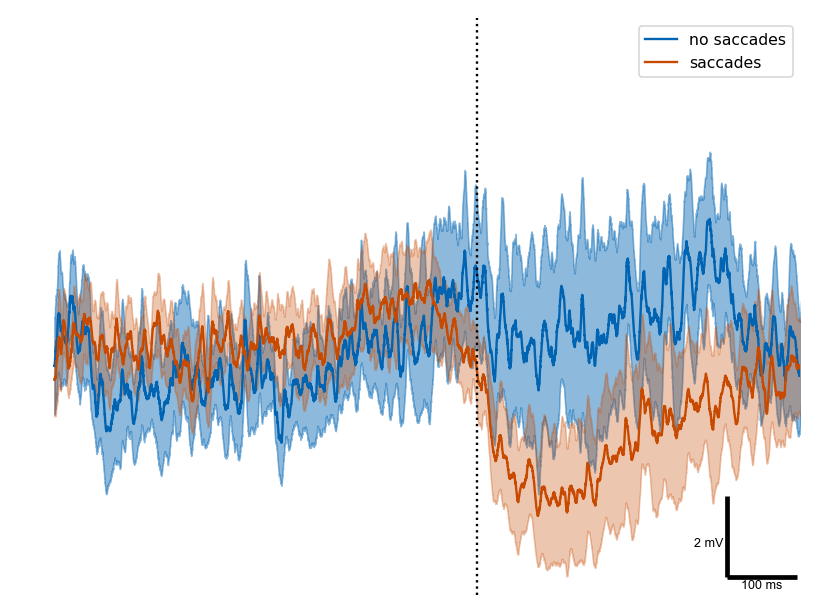

In [36]:
# membrane potential

# assert that we have equal datasets
strgSet = set([v for _,v in saStrg_Rhyp.flyID.items()])
saccSet = set([v for _,v in saSacc_Rhyp.flyID.items()])

''' MASSIVE NO-GO FOR NOW; BECAUSE I NEED TO FIX THE FLYID THING'''
#assert(strgSet == restSet)
#assert(saccSet == restSet)

f,ax=plt.subplots(1,1)
preSacc = 0.6 #s
postSacc = 0.5 #s
maxLoom = (saSacc_Rhyp.preStim+saSacc_Rhyp.stimulusPhases_inframes[1]*saSacc_Rhyp.meanFramePeriod)*saSacc_Rhyp.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc_Rhyp.samplingRate), int(maxLoom+postSacc*saSacc_Rhyp.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc_Rhyp.samplingRate-preSacc#-saSacc_Rhyp[i].preStim

d = saStrg_Rhyp.get_avg_data('ephys')
s = saStrg_Rhyp.get_std_data('ephys')
ax.plot(timeSlice, d[2][timeLims[0]:timeLims[1]]*100., color=plotColors[0])
ax.fill_between(timeSlice, 100.*(d[2]+s[2])[timeLims[0]:timeLims[1]], 100.*(d[2]-s[2])[timeLims[0]:timeLims[1]],
               color=plotColors[0], alpha=plotAlphas[0])

d = saSacc_Rhyp.get_avg_data('ephys')
s = saSacc_Rhyp.get_std_data('ephys')
ax.plot(timeSlice, d[2][timeLims[0]:timeLims[1]]*100., color=plotColors[2])
ax.fill_between(timeSlice, 100.*(d[2]+s[2])[timeLims[0]:timeLims[1]], 100.*(d[2]-s[2])[timeLims[0]:timeLims[1]],
               color=plotColors[2], alpha=plotAlphas[2])

#ax.set_title('saccades to right')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.set_xlim([-preSacc, postSacc])
ax.axvline(0, linestyle=':', color='k')
ax.legend(['no saccades','saccades'])


ax.set_xlim(PLOT_TIMEWINDOW)
# ax.set_ylim([-4.8,6.5]) #avgSEM
ax.set_ylim([-6.,8.35]) #avgSTD-byStimSig
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=2.0, labely='2 mV', barwidth=3)
plt.tight_layout()



## Fig 4E
Load datasets although we did that before in section 5.1, but it shoudln't be necessary to run that first.

In [39]:
saSacc_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__CWTdetection_saccading.neomat'))
saStrg_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__CWTdetection_straight.neomat'))
saSacc_Rnop.clean_flyIDs()
saStrg_Rnop.clean_flyIDs()
saSacc_Rnop.reallocate_fly_indices()
saStrg_Rnop.reallocate_fly_indices()

In [40]:
saSacc_Rnop.baseline_correct_data(baseline_startpoint=int((saSacc_Rnop.preStim+0.15)*saSacc_Rnop.samplingRate))
saStrg_Rnop.baseline_correct_data(baseline_startpoint=int((saStrg_Rnop.preStim+0.15)*saStrg_Rnop.samplingRate))
saSacc_Rnop.average_by_stimSignal()
saStrg_Rnop.average_by_stimSignal()

<IPython.core.display.Javascript object>


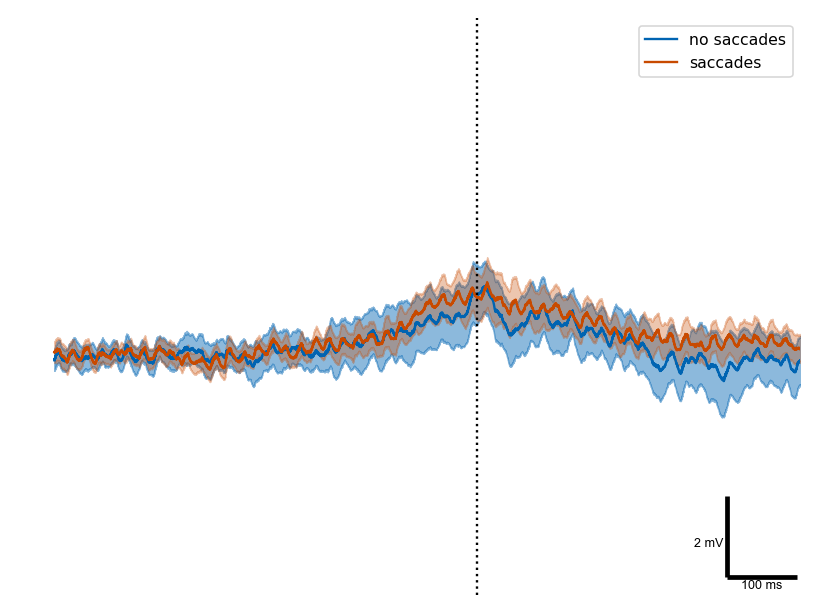

In [44]:
# membrane potential

# assert that we have equal datasets
strgSet = set([v for _,v in saStrg_Rnop.flyID.items()])
saccSet = set([v for _,v in saSacc_Rnop.flyID.items()])

''' MASSIVE NO-GO FOR NOW; BECAUSE I NEED TO FIX THE FLYID THING'''
#assert(strgSet == restSet)
#assert(saccSet == restSet)

f,ax=plt.subplots(1,1)
preSacc = 0.6 #s
postSacc = 0.5 #s
maxLoom = (saSacc_Rnop.preStim+saSacc_Rnop.stimulusPhases_inframes[1]*saSacc_Rnop.meanFramePeriod)*saSacc_Rnop.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc_Rnop.samplingRate), int(maxLoom+postSacc*saSacc_Rnop.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc_Rnop.samplingRate-preSacc#-saSacc_Rnop[i].preStim

d = saStrg_Rnop.get_avg_data('ephys')
s = saStrg_Rnop.get_std_data('ephys')
ax.plot(timeSlice, d[2][timeLims[0]:timeLims[1]]*100., color=plotColors[0])
ax.fill_between(timeSlice, 100.*(d[2]+s[2])[timeLims[0]:timeLims[1]], 100.*(d[2]-s[2])[timeLims[0]:timeLims[1]],
               color=plotColors[0], alpha=plotAlphas[0])

d = saSacc_Rnop.get_avg_data('ephys')
s = saSacc_Rnop.get_std_data('ephys')
ax.plot(timeSlice, d[2][timeLims[0]:timeLims[1]]*100., color=plotColors[2])
ax.fill_between(timeSlice, 100.*(d[2]+s[2])[timeLims[0]:timeLims[1]], 100.*(d[2]-s[2])[timeLims[0]:timeLims[1]],
               color=plotColors[2], alpha=plotAlphas[2])

#ax.set_title('saccades to right')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.set_xlim([-preSacc, postSacc])
ax.axvline(0, linestyle=':', color='k')
ax.legend(['no saccades','saccades'])


ax.set_xlim(PLOT_TIMEWINDOW)
# ax.set_ylim([-4.8,6.5]) #avgSEM
ax.set_ylim([-6.,8.35]) #avgSTD-byStimSig
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=2.0, labely='2 mV', barwidth=3)
plt.tight_layout()



## loading data for panels F&G

In [142]:
# LOAD DATASETS JUST TO GET THE LIST OF FLIES ASSOCIATED WITH EACH GROUP
# IF you have an alternative way, go ahead. Like using the ids straight from Fig 3C or D&E instead

saFly_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                          'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__flying.neomat'))
saFly_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                          'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__flying.neomat'))
saFly_Rhyp.clean_flyIDs()
saFly_Rnop.clean_flyIDs()
saFly_Rhyp.reallocate_fly_indices()
saFly_Rnop.reallocate_fly_indices()

In [143]:
hyPolSet = set([flyid.lower() for _,flyid in saFly_Rhyp.flyID.items()])
noPolSet = set([flyid.lower() for _,flyid in saFly_Rnop.flyID.items()])

assert(noPolSet.isdisjoint(hyPolSet))

In [ ]:
# in this figure _variableX_noPol refers to those from the NP_contra group
# and _variableX_hyPol refers to those from the HP_contra group

allSaccLeftMeanEphys_noPol = {}
allSaccLeftMeanWBA_noPol = {}
allSaccRightMeanEphys_noPol = {}
allSaccRightMeanWBA_noPol = {}

allSaccLeftMeanEphys_hyPol = {}
allSaccLeftMeanWBA_hyPol = {}
allSaccRightMeanEphys_hyPol = {}
allSaccRightMeanWBA_hyPol = {}


# load NP_contra spontaneous saccade data, relying on existing data structure
for flyID in noPolSet:
    print(flyID)
    fn = os.path.join(DATAPATH, 'spontaneousSaccades','CWTdetection',
                      f'{flyID}_looming_wb_spontSaccades_cwtDetection.neomat')
    da = DummyAnalyzer.retrieveFromNeomatfile(fn)
    #assert (da.flyID[0]==flyID.lower())
    if max(abs(da.saccLeftMeanEphys)) >0.1:
        da.saccLeftMeanEphys /= 100.
        da.saccRightMeanEphys /= 100.
    if abs(da.samplingRate -10000) >10:
        da.saccLeftMeanEphys = signal.resample(da.saccLeftMeanEphys, int(da.saccLeftMeanEphys.size/da.samplingRate*10000.))
        da.saccRightMeanEphys = signal.resample(da.saccRightMeanEphys, int(da.saccRightMeanEphys.size/da.samplingRate*10000.))
        da.saccLeftMeanWBA = signal.resample(da.saccLeftMeanWBA, int(da.saccLeftMeanWBA.size/da.samplingRate*10000.))
        da.saccRightMeanWBA = signal.resample(da.saccRightMeanWBA, int(da.saccRightMeanWBA.size/da.samplingRate*10000.))
    allSaccLeftMeanEphys_noPol[da.flyID[0]] = da.saccLeftMeanEphys
    allSaccRightMeanEphys_noPol[da.flyID[0]] = da.saccRightMeanEphys
    allSaccLeftMeanWBA_noPol[da.flyID[0]] = da.saccLeftMeanWBA*180./np.pi
    allSaccRightMeanWBA_noPol[da.flyID[0]] = da.saccRightMeanWBA*180./np.pi
    
# load HP_contra spontaneous saccade data,  relying on existing data structure
for flyID in hyPolSet:
    print(flyID)
    fn = os.path.join(DATAPATH, 'spontaneousSaccades','CWTdetection',
                      f'{flyID}_looming_wb_spontSaccades_cwtDetection.neomat')
    da = DummyAnalyzer.retrieveFromNeomatfile(fn)
    #assert (da.flyID[0]==flyID.lower())
    if max(abs(da.saccLeftMeanEphys)) >0.1:
        da.saccLeftMeanEphys /= 100.
        da.saccRightMeanEphys /= 100.
    if abs(da.samplingRate -10000) >10:
        da.saccLeftMeanEphys = signal.resample(da.saccLeftMeanEphys, int(da.saccLeftMeanEphys.size/da.samplingRate*10000.))
        da.saccRightMeanEphys = signal.resample(da.saccRightMeanEphys, int(da.saccRightMeanEphys.size/da.samplingRate*10000.))
        da.saccLeftMeanWBA = signal.resample(da.saccLeftMeanWBA, int(da.saccLeftMeanWBA.size/da.samplingRate*10000.))
        da.saccRightMeanWBA = signal.resample(da.saccRightMeanWBA, int(da.saccRightMeanWBA.size/da.samplingRate*10000.))
    allSaccLeftMeanEphys_hyPol[da.flyID[0]] = da.saccLeftMeanEphys
    allSaccRightMeanEphys_hyPol[da.flyID[0]] = da.saccRightMeanEphys
    allSaccLeftMeanWBA_hyPol[da.flyID[0]] = da.saccLeftMeanWBA*180./np.pi
    allSaccRightMeanWBA_hyPol[da.flyID[0]] = da.saccRightMeanWBA*180./np.pi

fly1_u29xg16_20200129_cell1
fly3_x21_20200415_cell1
fly3_x21_20200417_cell1
fly1_g06xu29_20191104_cell1
fly1_u29xg16_20191209_cell2
fly1_x20a_20200316_cell1
fly3_u29xg16_20200129_cell1
fly1_wtcs_20191106_cell1
fly2_x20_20210217_cell1


## Fig 4F
Plot spontaneous saccades L-R WSA for subsets in one plot

In [ ]:
f,ax = plt.subplots(1,1)

plotcolors = plt.cm.YlGn(np.linspace(0.3,0.6,len(allSaccRightMeanWBA_noPol)))
#plotcolors = plt.cm.YlOrBr(np.linspace(0.3,0.7,len(allSaccRightMeanWBA_noPol)))
i=0
for fid, data in allSaccRightMeanWBA_noPol.items():
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1.)
    i+=1
# add average line
minLen = min([data.size for _,data in allSaccRightMeanWBA_noPol.items()])
alldata = np.array([data[:minLen] for _,data in allSaccRightMeanWBA_noPol.items()])
avg_Rnop = np.mean(alldata, axis=0)
del alldata, plotcolors

plotcolors = plt.cm.Purples(np.linspace(0.45,0.7,len(allSaccRightMeanWBA_hyPol)))
i=0
for fid, data in allSaccRightMeanWBA_hyPol.items():
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1.)
    i+=1
# add average line
minLen = min([data.size for _,data in allSaccRightMeanWBA_hyPol.items()])
alldata = np.array([data[:minLen] for _,data in allSaccRightMeanWBA_hyPol.items()])
avg_Rhyp = np.mean(alldata, axis=0)
del alldata, plotcolors

# ax.set_title('sacc right WBA')
# ax.set_xlabel('time from onset [s]')

# compute and add global average (weighted average of the two group averages, number of members as weight)
minLen = min([avg_Rnop.size, avg_Rhyp.size])
avgAll = ((avg_Rnop[:minLen]*len(saFly_Rnop.flyID) + avg_Rhyp[:minLen]*len(saFly_Rhyp.flyID))
          / (len(saFly_Rnop.flyID) + len(saFly_Rhyp.flyID)) )
ax.plot(np.arange(avgAll.size)/10000-0.15, avgAll, color=[0.3,0.3,0.3], linewidth=2)
ax.plot(np.arange(avg_Rhyp.size)/10000.-0.15,avg_Rhyp, color=plt.cm.Purples(0.98), linewidth=2)
ax.plot(np.arange(avg_Rnop.size)/10000.-0.15,avg_Rnop, color=plt.cm.YlGn(0.85), linewidth=2.5)

ax.set_xlim([-0.15,0.48])
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=5., labely='5 °', barwidth=3)
plt.tight_layout()

## Fig 4G

<IPython.core.display.Javascript object>


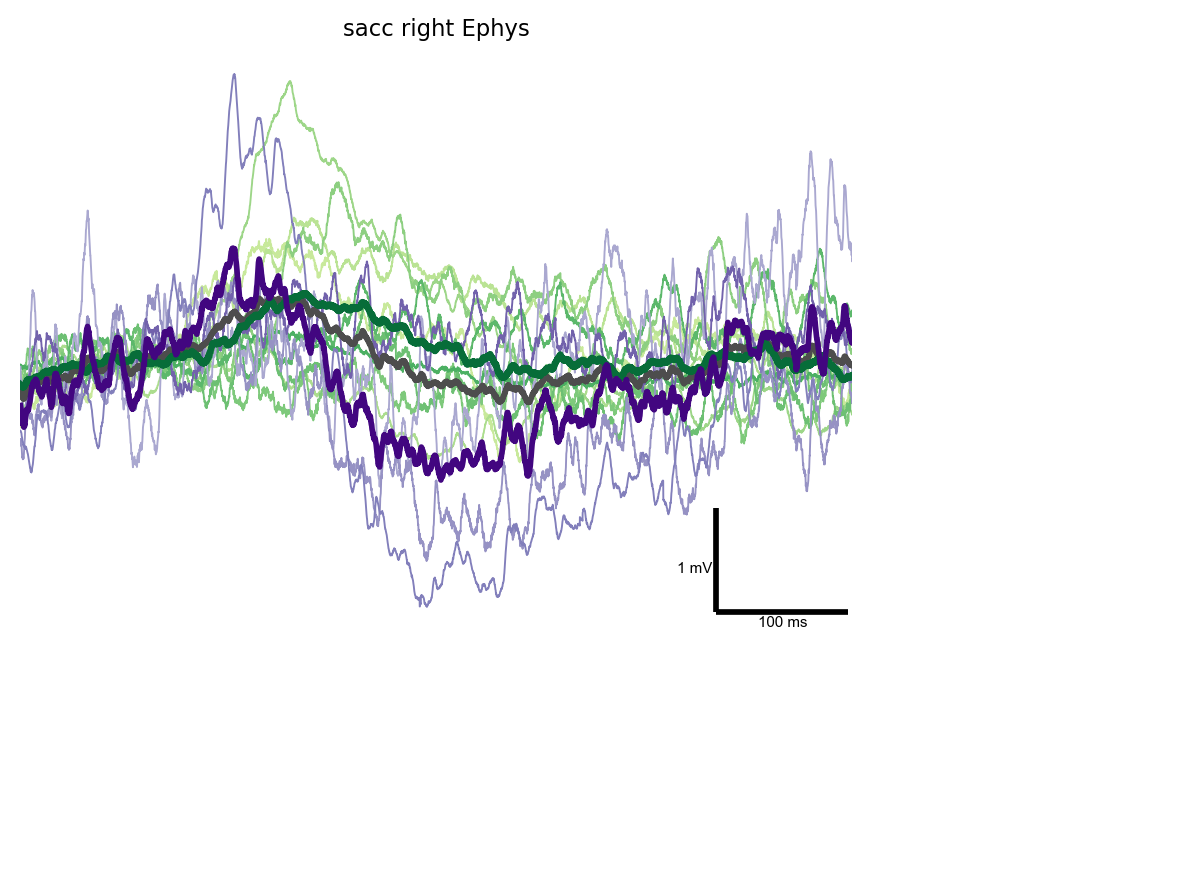

In [80]:
# first plot NP_contra in green, then HP_contra in purple
# average lines per group and all flies total are plotted at the end so they end up on top

f,ax = plt.subplots(1,1)

plotcolors = plt.cm.YlGn(np.linspace(0.3,0.6,len(allSaccRightMeanEphys_noPol)))
#plotcolors = plt.cm.YlOrBr(np.linspace(0.3,0.7,len(allSaccRightMeanEphys_noPol)))
i=0
for fid, data in allSaccRightMeanEphys_noPol.items():
    ax.plot(np.arange(data.size)/10000.-0.15, data*100., color=plotcolors[i], linewidth=1.)
    i+=1
# add average line
minLen = min([data.size for _,data in allSaccRightMeanEphys_noPol.items()])
alldata = np.array([data[:minLen] for _,data in allSaccRightMeanEphys_noPol.items()])
avg_Rnop = np.mean(alldata, axis=0)
del alldata, plotcolors

plotcolors = plt.cm.Purples(np.linspace(0.45,0.7,len(allSaccRightMeanEphys_hyPol)))
i=0
for fid, data in allSaccRightMeanEphys_hyPol.items():
    ax.plot(np.arange(data.size)/10000.-0.15, data*100., color=plotcolors[i], linewidth=1.)
    i+=1
# add average line
minLen = min([data.size for _,data in allSaccRightMeanEphys_hyPol.items()])
alldata = np.array([data[:minLen] for _,data in allSaccRightMeanEphys_hyPol.items()])
avg_Rhyp = np.mean(alldata, axis=0)
del alldata, plotcolors

# compute and add global average (weighted average of the two group averages, number of members as weight)
minLen = min([avg_Rnop.size, avg_Rhyp.size])
avgAll = ((avg_Rnop[:minLen]*len(saFly_Rnop.flyID) + avg_Rhyp[:minLen]*len(saFly_Rhyp.flyID))
          / (len(saFly_Rnop.flyID) + len(saFly_Rhyp.flyID)) )

# plot average lines here in certain order for better visibility (they end up on top) 
ax.plot(np.arange(avgAll.size)/10000-0.15, avgAll*100., color=[0.3,0.3,0.3], linewidth=3)
ax.plot(np.arange(avg_Rnop.size)/10000.-0.15,avg_Rnop*100., color=plt.cm.YlGn(0.85), linewidth=3.5)
ax.plot(np.arange(avg_Rhyp.size)/10000.-0.15,avg_Rhyp*100., color=plt.cm.Purples(0.98), linewidth=3)


ax.set_xlim([-0.15,0.48])
ax.set_title('sacc right Ephys')
ax.set_xlabel('time from onset [s]')
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=1.0, labely='1 mV', barwidth=3)
plt.tight_layout()

# Figure 5

In [64]:
PLOT_Y_LIMS = np.array([-3, 8.])
PLOT_TIMEWINDOW = [-0.4,0.46]
PLOT_LEGEND = ['horizontal motion only','rest', 'saccades']

## Fig 5A

In [40]:
# simpler alternative
saFly_Lhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_HyPol__flying.neomat'))
saRest_Lhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_HyPol__resting.neomat'))

In [41]:
# saccading trials
saSacc_Lhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_HyPol__CWTdetection_saccading.neomat'))
#saSacc_Lhyp.clean_flyIDs()
#saSacc_Lhyp.reallocate_fly_indices()
saSacc_Lhyp.flyID

{0: 'fly1_WTCS_20180725_cell1',
 1: 'fly4_X21_20200420_cell1',
 2: 'fly1_U29xG06_20190213_cell1',
 3: 'fly1_WTCS_20190726_cell1',
 4: 'fly3_U29xG16_20200129_cell1',
 5: 'fly1_X20a_20200316_cell1'}

In [42]:
saRest_Lhyp.average_by_stimSignal()
saSacc_Lhyp.average_by_stimSignal()
saFly_Lhyp.average_by_stimSignal()

<IPython.core.display.Javascript object>


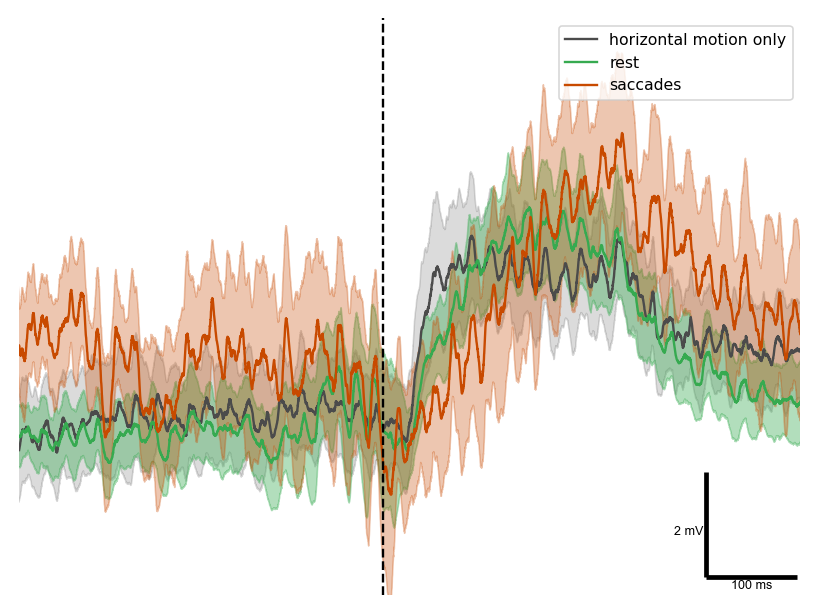

In [65]:
# prettier, clean plotting, membrane potential
stimID = 3

# assert that we have equal datasets
restSet = set([v.lower() for _,v in saRest_Lhyp.flyID.items()])
flySet = set([v.lower() for _,v in saSacc_Lhyp.flyID.items()])
assert(flySet == restSet)

f,ax=plt.subplots(1,1)
preSacc = 0.65 #s
postSacc = 0.5 #s
maxLoom = (saSacc_Lhyp.preStim+saSacc_Lhyp.stimulusPhases_inframes[1]*saSacc_Lhyp.meanFramePeriod)*saSacc_Lhyp.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc_Lhyp.samplingRate), int(maxLoom+postSacc*saSacc_Lhyp.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc_Lhyp.samplingRate-preSacc#-saSacc_Lhyp[i].preStim


d = saFly_Lhyp.get_avg_data('ephys')
s = saFly_Lhyp.get_std_data('ephys')
ax.plot(timeSlice, d[6][timeLims[0]:timeLims[1]]*100., color=optomotorColor)
ax.fill_between(timeSlice, 100.*(d[6]+s[6])[timeLims[0]:timeLims[1]], 100.*(d[6]-s[6])[timeLims[0]:timeLims[1]],
                alpha=optomotorAlpha, color=optomotorColor)

d = saRest_Lhyp.get_avg_data('ephys')
s = saRest_Lhyp.get_std_data('ephys')
ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100., color=plotColors[1])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]],
                 color=plotColors[1], alpha=plotAlphas[1])

d = saSacc_Lhyp.get_avg_data('ephys')
s = saSacc_Lhyp.get_std_data('ephys')

ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100.,  color=plotColors[2])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]], 
               color=plotColors[2], alpha=plotAlphas[2])

#ax.set_title('saccades to left and rotation right')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.set_xlim(PLOT_TIMEWINDOW)
ax.axvline(0, linestyle='--', color='k')
ax.legend(PLOT_LEGEND)
ax.set_ylim(PLOT_Y_LIMS)

#f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=2.0, labely='2 mV', barwidth=3)
plt.tight_layout()

## Fig 5B

In [45]:
# simpler alternative
saFly_Lnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_NoPol__flying.neomat'))
saRest_Lnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_NoPol__resting.neomat'))

In [46]:
saFly_Lnop.flyID, saRest_Lnop.flyID

({0: 'fly1_G06xU29_20191104_cell1',
  1: 'fly1_U29xG16_20191209_cell2',
  2: 'fly3_X21_20200415_cell1',
  3: 'fly3_x21_20200417_cell1',
  4: 'fly2_X20_20210217_cell1'},
 {0: 'fly1_G06xU29_20191104_cell1',
  1: 'fly1_U29xG16_20191209_cell2',
  2: 'fly3_X21_20200415_cell1',
  3: 'fly3_x21_20200417_cell1',
  4: 'fly2_X20_20210217_cell1'})

In [47]:
# saccading trials
saSacc_Lnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                             'Collections_saccade_straight',
                             'saccLeft_NoPol__CWTdetection_saccading.neomat'))
saSacc_Lnop.flyID

{0: 'fly1_G06xU29_20191104_cell1',
 1: 'fly1_U29xG16_20191209_cell2',
 2: 'fly3_X21_20200415_cell1',
 3: 'fly3_x21_20200417_cell1',
 4: 'fly2_X20_20210217_cell1'}

In [54]:
saRest_Lnop.average_flywise()
saSacc_Lnop.average_flywise()
saFly_Lnop.average_flywise()

<IPython.core.display.Javascript object>


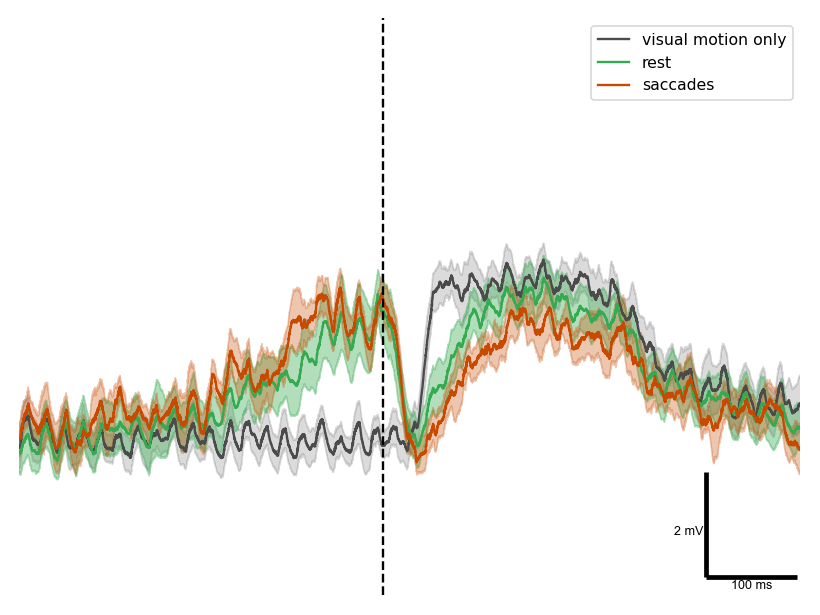

In [63]:
# prettier, clean plotting, membrane potential
stimID = 3
# assert that we have equal datasets
restSet = set([v.lower() for _,v in saRest_Lnop.flyID.items()])
flySet = set([v.lower() for _,v in saSacc_Lnop.flyID.items()])
assert(flySet == restSet)

f,ax=plt.subplots(1,1)
preSacc = 0.65 #s
postSacc = 0.5 #s
maxLoom = (saSacc_Lnop.preStim+saSacc_Lnop.stimulusPhases_inframes[1]*saSacc_Lnop.meanFramePeriod)*saSacc_Lnop.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc_Lnop.samplingRate), int(maxLoom+postSacc*saSacc_Lnop.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc_Lnop.samplingRate-preSacc#-saSacc_Lnop[i].preStim


# d = saRest_Lnop.get_avg_data('ephys')
# s = saRest_Lnop.get_std_data('ephys')
d = saFly_Lnop.get_avg_data('ephys')
s = saFly_Lnop.get_std_data('ephys')
ax.plot(timeSlice, d[6][timeLims[0]:timeLims[1]]*100., color=optomotorColor)
ax.fill_between(timeSlice, 100.*(d[6]+s[6])[timeLims[0]:timeLims[1]], 100.*(d[6]-s[6])[timeLims[0]:timeLims[1]],
                alpha=optomotorAlpha, color=optomotorColor)

d = saRest_Lnop.get_avg_data('ephys')
s = saRest_Lnop.get_std_data('ephys')
ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100., color=plotColors[1])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]],
                color=plotColors[1], alpha=plotAlphas[1])

d = saSacc_Lnop.get_avg_data('ephys')
s = saSacc_Lnop.get_std_data('ephys')
ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100., color=plotColors[2])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]], 
               color=plotColors[2], alpha=plotAlphas[2])

#ax.set_title('saccades to left and rotation right')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.axvline(0, linestyle='--', color='k')
ax.legend(['visual motion only','rest', 'saccades'])
ax.set_ylim(PLOT_Y_LIMS)

ax.set_xlim(PLOT_TIMEWINDOW)
#f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=2.0, labely='2 mV', barwidth=3)
plt.tight_layout()

## Fig 5C
Here the data is simply loaded and plotted. For details on how to compute (and save) these values and separate section on statistical tests, see notebook "slopeInhibitionQuantification"

The sections where panels A and B of this figure are loading their data need to be executed as well, simply because we need the list of which flies count as NP/HPspont.

In [48]:
#load data
d = pickle.load(open(os.path.join(DATAPATH,'Figures4Paper', 'slopeInhibition_quantified',
                              'slopeInhibition_simple_Vm_resting-saccades_windowAt4.0frames.pickle'),'rb'))
print(d.keys())
# declare variable names expected downstream
restingSlopeDict = d['restingSlopeDict']
saccadeSlopeDict = d['saccadeSlopeDict']
flyingSlopeDict = d['flyingSlopeDict']

dict_keys(['restingSlopeDict', 'saccadeSlopeDict', 'flyingSlopeDict'])


In [49]:
# set stimuli to compare
combi_stimID = 3
opmot_stimID = 6

print(f'combi_stimID={combi_stimID} , opmot_stimID={opmot_stimID}')
saFly_Lhyp.get_stimulusmap(combi_stimID), saFly_Lhyp.get_stimulusmap(opmot_stimID)

combi_stimID=3 , opmot_stimID=6


('loom right rot. clw', 'no loom rot. clw')

In [50]:
#HP/NPspont
hypolFlies = [v.lower() for _,v in saSacc_Lhyp.flyID.items() if v.lower()!='fly1_x20a_20200316_cell1' ] #HP group, not enough trials in this fly for stim 3
nopolFlies = [v.lower() for _,v in saSacc_Lnop.flyID.items()] #NP group

In [51]:
# consider the response to combined stim, normalized by optomotor resp
combiRest_hyp = [restingSlopeDict[fid][combi_stimID][0]  for fid in hypolFlies]
combiSacc_hyp = [saccadeSlopeDict[fid][combi_stimID][0]  for fid in hypolFlies]

combiRest_nop = [restingSlopeDict[fid][combi_stimID][0]  for fid in nopolFlies]
combiSacc_nop = [saccadeSlopeDict[fid][combi_stimID][0]  for fid in nopolFlies]

opmotFly_hyp = [flyingSlopeDict[fid][opmot_stimID][0]  for fid in hypolFlies]
opmotFly_nop = [flyingSlopeDict[fid][opmot_stimID][0]  for fid in nopolFlies]
opmotRest_hyp = [restingSlopeDict[fid][opmot_stimID][0]  for fid in hypolFlies]
opmotRest_nop = [restingSlopeDict[fid][opmot_stimID][0]  for fid in nopolFlies]

ShapiroResult(statistic=0.8762288093566895, pvalue=0.29256966710090637)
Ttest_relResult(statistic=-2.101816603901617, pvalue=0.05172048360185302)


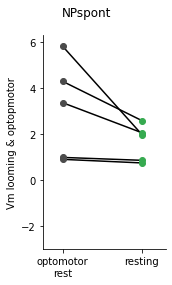

In [57]:
# plot changes for NP/HP spont group, not normalized

# NP group
opmotRest = opmotRest_nop
combiRest = combiRest_nop

# plot
f,ax=plt.subplots(figsize=(2.5,4))

#plotting markers and lines separate for easier handling of details later
ax.plot(np.vstack((np.zeros_like(opmotRest), np.ones_like(combiRest))), 
        np.vstack((opmotRest, combiRest)),
           #'-', color=plt.cm.Greens(0.9), alpha=0.4)
        '-',color='k', zorder=0)

ax.scatter(np.zeros_like(opmotRest), opmotRest, marker='o', color=np.array([75,75,75])/255)
ax.scatter(np.ones_like(combiRest), combiRest, marker='o', color=(54/255, 170/255, 80/255))

ax.set_xlim([-0.25,1.3])
ax.set_xticks([0,1])
ax.set_xticklabels(['optomotor\nrest','resting'])

ax.set_ylabel('membrane potential')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([-2, 0, 2, 4, 6])
ax.set_ylim([-3, 6.3])
f.suptitle('NPspont')
plt.tight_layout()

print(stats.shapiro(np.array(opmotRest)-np.array(combiRest)))
print(stats.ttest_rel(combiRest, opmotRest, alternative='less'))
# print(stats.wilcoxon(opmotRest, combiRest)) #data is normal -> t-test

optmotor non-flight vs combined non-flight (grey vs green)
ShapiroResult(statistic=0.8968878984451294, pvalue=0.39292487502098083)
Ttest_relResult(statistic=-5.473243666602155, pvalue=0.005422679311162783)

combined non-flight vs combined in saccades (red vs green)
HP group normality test: ShapiroResult(statistic=0.7400357723236084, pvalue=0.02400333061814308)
HP group: Ttest_relResult(statistic=-3.929371079610029, pvalue=0.008556033332201098)
not normal distributed, therefore Wilcoxon
HP group: WilcoxonResult(statistic=0.0, pvalue=0.03125)


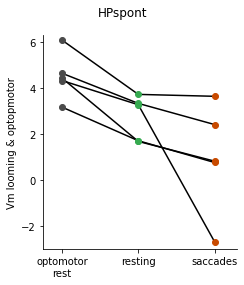

In [64]:
# plot changes for NP/HP spont group, not normalized

# HP group
opmotRest = opmotRest_hyp
combiRest = combiRest_hyp
combiSacc = combiSacc_hyp

# plot
f,ax=plt.subplots(figsize=(3.5,4))

#plotting markers and lines separate for easier handling of details later
ax.plot(np.vstack((np.zeros_like(opmotRest), np.ones_like(combiRest), np.full_like(combiSacc, 2))), 
        np.vstack((opmotRest, combiRest, combiSacc)),
           #'-', color=plt.cm.Greens(0.9), alpha=0.4)
        '-',color='k', zorder=0)

ax.scatter(np.zeros_like(opmotRest), opmotRest, marker='o', color=np.array([75,75,75])/255)
ax.scatter(np.ones_like(combiRest), combiRest, marker='o', color=(54/255, 170/255, 80/255))
ax.scatter(np.full_like(combiSacc,2), combiSacc, marker='o', color=(200/255, 74/255, 0/255))

ax.set_xlim([-0.25,2.3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['optomotor\nrest','resting','saccades'])

ax.set_ylabel('membrane potential')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([-2, 0, 2, 4, 6])
ax.set_ylim([-3, 6.3])
f.suptitle('HPspont')
plt.tight_layout()

print('optmotor non-flight vs combined non-flight (grey vs green)')
print(stats.shapiro(np.array(opmotRest)-np.array(combiRest)))
print(stats.ttest_rel(combiRest, opmotRest, alternative='two-sided'))

print('\ncombined non-flight vs combined in saccades (red vs green)')
print(f'HP group normality test: {stats.shapiro(np.array(combiSacc)-np.array(opmotRest))}')
print(f"HP group: {stats.ttest_rel(combiSacc, opmotRest, alternative='less')}") #for CLW rot.
print("not normal distributed, therefore Wilcoxon")
print(f"HP group: {stats.wilcoxon(combiSacc, opmotRest, alternative='less', mode='exact')}") #for CLW rot.

## Fig 5D

In [15]:
saFly_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__flying.neomat'))
saRest_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__resting.neomat'))
saSacc_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_saccading.neomat'))
# saStrg_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
#                             'Collections_saccade_straight', 'newSorting',
#                             'loomLeft_hyPol__CWTdetection_straight.neomat'))

In [81]:
saSacc_Rhyp.average_flywise()
saFly_Rhyp.average_flywise()
saRest_Rhyp.average_flywise()

<IPython.core.display.Javascript object>


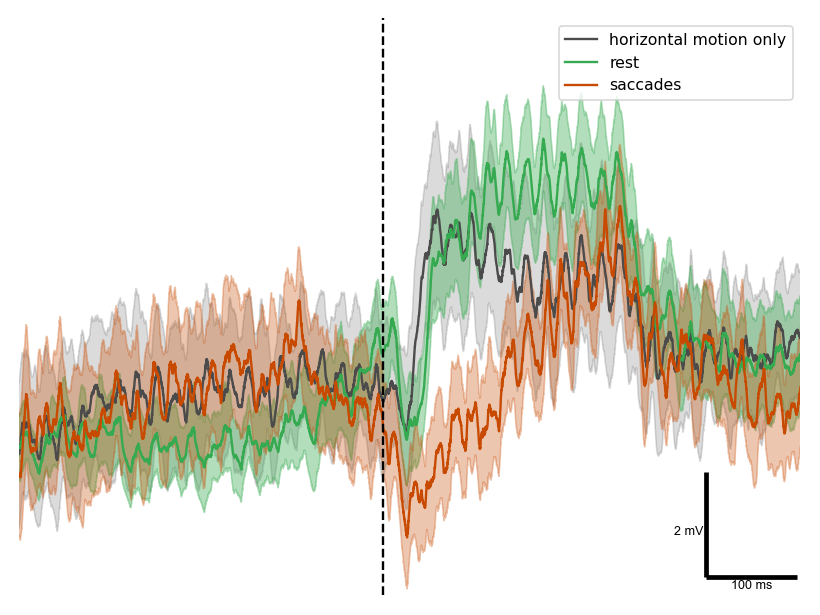

In [84]:
# prettier, clean plotting, membrane potential
stimID = 0
# assert that we have equal datasets
restSet = set([v.lower() for k,v in saRest_Rhyp.flyID.items()])
flySet = set([v.lower() for k,v in saSacc_Rhyp.flyID.items()])
assert(flySet == restSet)

f,ax=plt.subplots(1,1)
preSacc = 0.65 #s
postSacc = 0.5 #s
maxLoom = (saSacc_Rhyp.preStim+saSacc_Rhyp.stimulusPhases_inframes[1]*saSacc_Rhyp.meanFramePeriod)*saSacc_Rhyp.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc_Rhyp.samplingRate), int(maxLoom+postSacc*saSacc_Rhyp.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc_Rhyp.samplingRate-preSacc#-saSacc_Rhyp[i].preStim


d = saFly_Rhyp.get_avg_data('ephys')
s = saFly_Rhyp.get_std_data('ephys')
ax.plot(timeSlice, d[6][timeLims[0]:timeLims[1]]*100., color=optomotorColor)
ax.fill_between(timeSlice, 100.*(d[6]+s[6])[timeLims[0]:timeLims[1]], 100.*(d[6]-s[6])[timeLims[0]:timeLims[1]],
                alpha=optomotorAlpha, color=optomotorColor)

d = saRest_Rhyp.get_avg_data('ephys')
s = saRest_Rhyp.get_std_data('ephys')
ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100., color=plotColors[1])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]],
               color=plotColors[1], alpha=plotAlphas[1])

d = saSacc_Rhyp.get_avg_data('ephys')
s = saSacc_Rhyp.get_std_data('ephys')
ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100., color=plotColors[2])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]], 
               color=plotColors[2], alpha=plotAlphas[2])

#ax.set_title('saccades to right and rotation right')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.axvline(0, linestyle='--', color='k')
ax.legend(PLOT_LEGEND)
ax.set_ylim(PLOT_Y_LIMS)

ax.set_xlim(PLOT_TIMEWINDOW)
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=2.0, labely='2 mV', barwidth=3)
plt.tight_layout()

## Fig 5E

In [18]:
saFly_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__flying.neomat'))
saRest_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__resting.neomat'))
saSacc_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__CWTdetection_saccading.neomat'))
# saStrg_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
#                             'Collections_saccade_straight', 'newSorting',
#                             'loomLeft_noPol__CWTdetection_straight.neomat'))

In [95]:
saFly_Rnop.flyID, saRest_Rnop.flyID

({0: 'fly3_U29xG16_20200129_cell1',
  1: 'fly1_X20a_20200316_cell1',
  2: 'fly1_WTCS_20191106_cell1',
  3: 'fly1_U29xG16_20200129_cell1',
  4: 'fly1_G06xU29_20191104_cell1',
  5: 'fly1_U29xG16_20191209_cell2',
  6: 'fly3_X21_20200415_cell1',
  7: 'fly3_x21_20200417_cell1',
  8: 'fly2_X20_20210217_cell1'},
 {0: 'fly3_U29xG16_20200129_cell1',
  1: 'fly1_X20a_20200316_cell1',
  2: 'fly1_WTCS_20191106_cell1',
  3: 'fly1_U29xG16_20200129_cell1',
  4: 'fly1_G06xU29_20191104_cell1',
  5: 'fly1_U29xG16_20191209_cell2',
  6: 'fly3_X21_20200415_cell1',
  7: 'fly3_x21_20200417_cell1',
  8: 'fly2_X20_20210217_cell1'})

In [81]:
saSacc_Rnop.average_flywise()
saFly_Rnop.average_flywise()
saRest_Rnop.average_flywise()

<IPython.core.display.Javascript object>


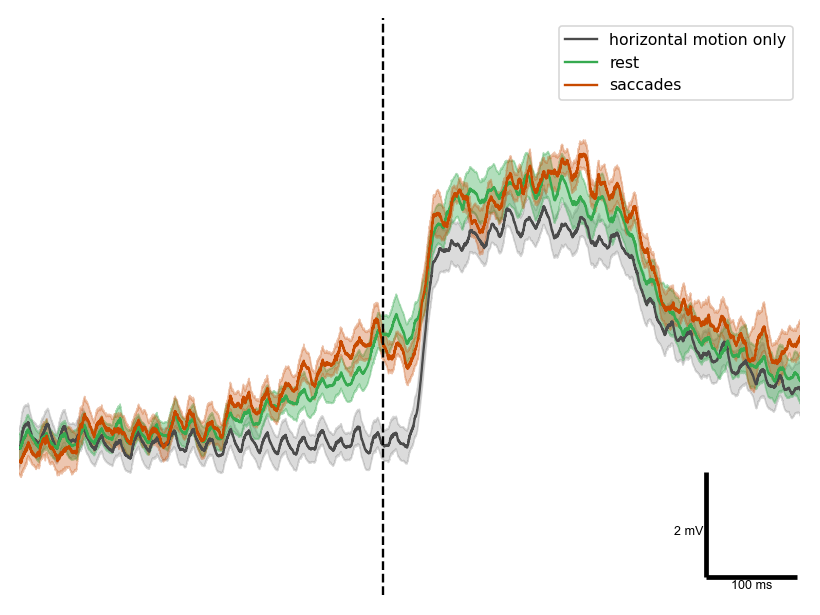

In [115]:
# prettier, clean plotting, membrane potential
stimID = 0
# assert that we have equal datasets
restSet = set([v.lower() for k,v in saRest_Rnop.flyID.items()])
flySet = set([v.lower() for k,v in saSacc_Rnop.flyID.items()])
assert(flySet == restSet)

f,ax=plt.subplots(1,1)
preSacc = 0.65 #s
postSacc = 0.5 #s
maxLoom = (saSacc_Rnop.preStim+saSacc_Rnop.stimulusPhases_inframes[1]*saSacc_Rnop.meanFramePeriod)*saSacc_Rnop.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc_Rnop.samplingRate), int(maxLoom+postSacc*saSacc_Rnop.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc_Rnop.samplingRate-preSacc#-saSacc_Rnop[i].preStim


d = saFly_Rnop.get_avg_data('ephys')
s = saFly_Rnop.get_std_data('ephys')
ax.plot(timeSlice, d[6][timeLims[0]:timeLims[1]]*100., color=optomotorColor)
ax.fill_between(timeSlice, 100.*(d[6]+s[6])[timeLims[0]:timeLims[1]], 100.*(d[6]-s[6])[timeLims[0]:timeLims[1]],
                alpha=optomotorAlpha, color=optomotorColor)

d = saRest_Rnop.get_avg_data('ephys')
s = saRest_Rnop.get_std_data('ephys')
ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100., color=plotColors[1])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]],
               color=plotColors[1], alpha=plotAlphas[1])

d = saSacc_Rnop.get_avg_data('ephys')
s = saSacc_Rnop.get_std_data('ephys')
ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100., color=plotColors[2])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]], 
               color=plotColors[2], alpha=plotAlphas[2])

#ax.set_title('saccades to right and rotation right')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.axvline(0, linestyle='--', color='k')
ax.legend(PLOT_LEGEND)
ax.set_ylim(PLOT_Y_LIMS)

ax.set_xlim(PLOT_TIMEWINDOW)
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=2.0, labely='2 mV', barwidth=3)
plt.tight_layout()

## Fig 5F
Same note as in 5C

The sections where panels D and E of this figure are loading their data need to be executed as well, simply because we need the list of which flies count as NP/HPcontra.

In [13]:
#load data, same as for Fig 5C, but plotting for different stimulus and groupings
d = pickle.load(open(os.path.join(DATAPATH,'Figures4Paper', 'slopeInhibition_quantified',
                              'slopeInhibition_simple_Vm_resting-saccades_windowAt4.0frames.pickle'),'rb'))
print(d.keys())
# declare variable names expected downstream
restingSlopeDict = d['restingSlopeDict']
saccadeSlopeDict = d['saccadeSlopeDict']
flyingSlopeDict = d['flyingSlopeDict']

dict_keys(['restingSlopeDict', 'saccadeSlopeDict', 'flyingSlopeDict'])


In [29]:
# set stimuli to compare
combi_stimID = 0
opmot_stimID = 6

print(f'combi_stimID={combi_stimID} , opmot_stimID={opmot_stimID}')
saFly_Rhyp.get_stimulusmap(combi_stimID), saFly_Rhyp.get_stimulusmap(opmot_stimID)

combi_stimID=0 , opmot_stimID=6


('loom left rot. clw', 'no loom rot. clw')

In [30]:
# HP/NPcontra
hypolFlies = [v.lower() for _,v in saSacc_Rhyp.flyID.items()]
nopolFlies = [v.lower() for _,v in saSacc_Rnop.flyID.items()]

In [31]:
# consider the response to combined stim, normalized by optomotor resp
combiRest_hyp = [restingSlopeDict[fid][combi_stimID][0]  for fid in hypolFlies]
combiSacc_hyp = [saccadeSlopeDict[fid][combi_stimID][0]  for fid in hypolFlies]

combiRest_nop = [restingSlopeDict[fid][combi_stimID][0]  for fid in nopolFlies]
combiSacc_nop = [saccadeSlopeDict[fid][combi_stimID][0]  for fid in nopolFlies]

opmotFly_hyp = [flyingSlopeDict[fid][opmot_stimID][0]  for fid in hypolFlies]
opmotFly_nop = [flyingSlopeDict[fid][opmot_stimID][0]  for fid in nopolFlies]
opmotRest_hyp = [restingSlopeDict[fid][opmot_stimID][0]  for fid in hypolFlies]
opmotRest_nop = [restingSlopeDict[fid][opmot_stimID][0]  for fid in nopolFlies]

significant difference optomotor only vs combined in saccades? (grey vs red)
ShapiroResult(statistic=0.7967464327812195, pvalue=0.01874570921063423)
Ttest_relResult(statistic=2.3269160560325095, pvalue=0.9758029443248973)
Not normal, Wilcoxon needed
WilcoxonResult(statistic=4.0, pvalue=0.013671875)


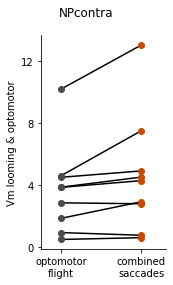

In [35]:
# plot for NP/HP group , optomotor and saccades

#for NPgroup
opmotFly = opmotFly_nop
combiSacc = combiSacc_nop


#plot
f,ax=plt.subplots(figsize=(2.5,4))

#plotting markers and lines separate for easier handling of details later
ax.plot(np.vstack((np.zeros_like(opmotFly), np.ones_like(combiSacc))), 
        np.vstack((opmotFly, combiSacc)),
           #'-', color=plt.cm.Greens(0.9), alpha=0.4)
        '-',color='k', zorder=0)

ax.scatter(np.zeros_like(opmotFly), opmotFly, marker='o', color=np.array([75,75,75])/255)
ax.scatter(np.ones_like(combiSacc), combiSacc, marker='o', color=(200/255, 74/255, 0/255))

ax.set_xlim([-0.25,1.3])
ax.set_xticks([0,1])
ax.set_xticklabels(['optomotor\nflight','combined\nsaccades'])

ax.set_ylabel('membrane potential')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 4, 8, 12])
# ax.set_ylim([-0.5, 13])
f.suptitle('NPcontra')
plt.tight_layout()

print('significant difference optomotor only vs combined in saccades? (grey vs red)')
print(stats.shapiro(np.array(opmotFly)-np.array(combiSacc)))
print(stats.ttest_rel(combiSacc, opmotFly, alternative='less'))
print('Not normal, Wilcoxon needed')
print(stats.wilcoxon(opmotFly, combiSacc, alternative='less', mode='exact'))

significant difference optomotor only vs combined in saccades? (grey vs red)
ShapiroResult(statistic=0.9962811470031738, pvalue=0.9869317412376404)
Ttest_relResult(statistic=-6.228320397801982, pvalue=0.004172765259130573)


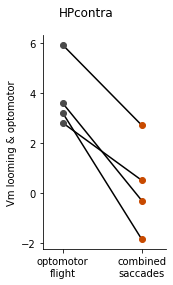

In [37]:
# plot for NP/HP group , optomotor and saccades

#for HP group
opmotFly = opmotFly_hyp
combiSacc = combiSacc_hyp

#plot
f,ax=plt.subplots(figsize=(2.5,4))

#plotting markers and lines separate for easier handling of details later
ax.plot(np.vstack((np.zeros_like(opmotFly), np.ones_like(combiSacc))), 
        np.vstack((opmotFly, combiSacc)),
           #'-', color=plt.cm.Greens(0.9), alpha=0.4)
        '-',color='k', zorder=0)

ax.scatter(np.zeros_like(opmotFly), opmotFly, marker='o', color=np.array([75,75,75])/255)
ax.scatter(np.ones_like(combiSacc), combiSacc, marker='o', color=(200/255, 74/255, 0/255))

ax.set_xlim([-0.25,1.3])
ax.set_xticks([0,1])
ax.set_xticklabels(['optomotor\nflight','combined\nsaccades'])

ax.set_ylabel('membrane potential')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([-2, 0, 2, 4, 6])
# ax.set_ylim([-2.5, 6.3])
f.suptitle('HPcontra')
plt.tight_layout()

print('significant difference optomotor only vs combined in saccades? (grey vs red)')
print(stats.shapiro(np.array(opmotFly)-np.array(combiSacc)))
print(stats.ttest_rel(combiSacc, opmotFly, alternative='less'))
# print(stats.wilcoxon(opmotFly, combiSacc, alternative='less', mode='exact')) #data is normal -> t-test

## Fig 5G
Uses the same data and same code as Fig 4C, only difference is the stimID

In [116]:
saFly_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__flying.neomat'))
saRest_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__resting.neomat'))
saSacc_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_saccading.neomat'))
# saStrg_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
#                             'Collections_saccade_straight', 'newSorting',
#                             'loomLeft_hyPol__CWTdetection_straight.neomat'))

In [117]:
saSacc_Rhyp.average_flywise()
saFly_Rhyp.average_flywise()
saRest_Rhyp.average_flywise()

<IPython.core.display.Javascript object>


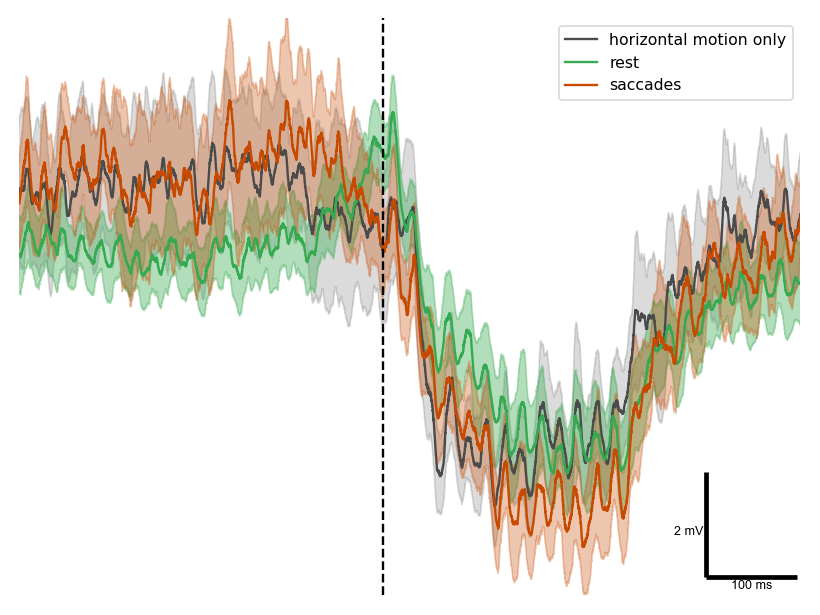

In [135]:
# prettier, clean plotting, membrane potential
stimID = 1
# assert that we have equal datasets
restSet = set([v.lower() for k,v in saRest_Rhyp.flyID.items()])
flySet = set([v.lower() for k,v in saSacc_Rhyp.flyID.items()])
assert(flySet == restSet)

f,ax=plt.subplots(1,1)
preSacc = 0.65 #s
postSacc = 0.5 #s
maxLoom = (saSacc_Rhyp.preStim+saSacc_Rhyp.stimulusPhases_inframes[1]*saSacc_Rhyp.meanFramePeriod)*saSacc_Rhyp.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc_Rhyp.samplingRate), int(maxLoom+postSacc*saSacc_Rhyp.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc_Rhyp.samplingRate-preSacc#-saSacc_Rhyp[i].preStim


d = saFly_Rhyp.get_avg_data('ephys')
s = saFly_Rhyp.get_std_data('ephys')
ax.plot(timeSlice, d[7][timeLims[0]:timeLims[1]]*100., color=optomotorColor)
ax.fill_between(timeSlice, 100.*(d[7]+s[7])[timeLims[0]:timeLims[1]], 100.*(d[7]-s[7])[timeLims[0]:timeLims[1]],
                alpha=optomotorAlpha, color=optomotorColor)

d = saRest_Rhyp.get_avg_data('ephys')
s = saRest_Rhyp.get_std_data('ephys')
ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100., color=plotColors[1])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]],
               color=plotColors[1], alpha=plotAlphas[1])

d = saSacc_Rhyp.get_avg_data('ephys')
s = saSacc_Rhyp.get_std_data('ephys')
ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100., color=plotColors[2])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]], 
               color=plotColors[2], alpha=plotAlphas[2])

#ax.set_title('saccades to right and rotation right')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.axvline(0, linestyle='--', color='k')
ax.legend(PLOT_LEGEND)
ax.set_ylim(PLOT_Y_LIMS-3.8)# needs adjustment to fit, not changing interval size

ax.set_xlim(PLOT_TIMEWINDOW)
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=2.0, labely='2 mV', barwidth=3)
plt.tight_layout()

## Fig 5H

In [91]:
saFly_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__flying.neomat'))
saRest_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__resting.neomat'))
saSacc_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__CWTdetection_saccading.neomat'))
# saStrg_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
#                             'Collections_saccade_straight', 'newSorting',
#                             'loomLeft_noPol__CWTdetection_straight.neomat'))

In [81]:
saSacc_Rnop.average_flywise()
saFly_Rnop.average_flywise()
saRest_Rnop.average_flywise()

<IPython.core.display.Javascript object>


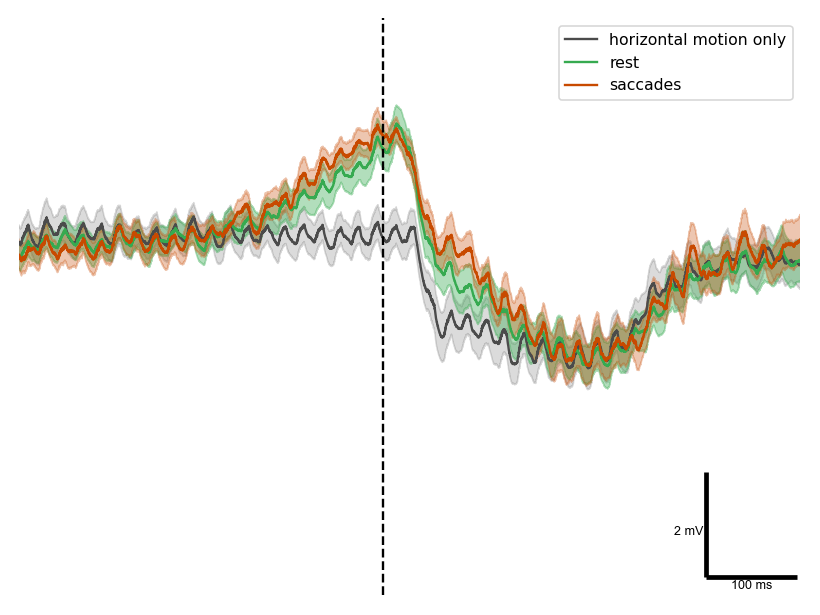

In [136]:
# prettier, clean plotting, membrane potential
stimID = 1
# assert that we have equal datasets
restSet = set([v.lower() for k,v in saRest_Rnop.flyID.items()])
flySet = set([v.lower() for k,v in saSacc_Rnop.flyID.items()])
assert(flySet == restSet)

f,ax=plt.subplots(1,1)
preSacc = 0.65 #s
postSacc = 0.5 #s
maxLoom = (saSacc_Rnop.preStim+saSacc_Rnop.stimulusPhases_inframes[1]*saSacc_Rnop.meanFramePeriod)*saSacc_Rnop.samplingRate
timeLims = [int(maxLoom-preSacc*saSacc_Rnop.samplingRate), int(maxLoom+postSacc*saSacc_Rnop.samplingRate)]
timeSlice = np.arange(timeLims[1]-timeLims[0])/saSacc_Rnop.samplingRate-preSacc#-saSacc_Rnop[i].preStim


d = saFly_Rnop.get_avg_data('ephys')
s = saFly_Rnop.get_std_data('ephys')
ax.plot(timeSlice, d[7][timeLims[0]:timeLims[1]]*100., color=optomotorColor)
ax.fill_between(timeSlice, 100.*(d[7]+s[7])[timeLims[0]:timeLims[1]], 100.*(d[7]-s[7])[timeLims[0]:timeLims[1]],
                alpha=optomotorAlpha, color=optomotorColor)

d = saRest_Rnop.get_avg_data('ephys')
s = saRest_Rnop.get_std_data('ephys')
ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100., color=plotColors[1])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]],
               color=plotColors[1], alpha=plotAlphas[1])

d = saSacc_Rnop.get_avg_data('ephys')
s = saSacc_Rnop.get_std_data('ephys')
ax.plot(timeSlice, d[stimID][timeLims[0]:timeLims[1]]*100., color=plotColors[2])
ax.fill_between(timeSlice, 100.*(d[stimID]+s[stimID])[timeLims[0]:timeLims[1]], 100.*(d[stimID]-s[stimID])[timeLims[0]:timeLims[1]], 
               color=plotColors[2], alpha=plotAlphas[2])

#ax.set_title('saccades to right and rotation right')
ax.set_ylabel('U [mV]')
ax.set_xlabel('time [s]')
ax.axvline(0, linestyle='--', color='k')
ax.legend(PLOT_LEGEND)
ax.set_ylim(PLOT_Y_LIMS-3.8)# needs adjustment to fit, not changing interval size

ax.set_xlim(PLOT_TIMEWINDOW)
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False, sizey=2.0, labely='2 mV', barwidth=3)
plt.tight_layout()

# Figure S1

Take the same fly as in the example raw data (Fig 1E), show a piece of Kinefly recording, then demonstrate the fitting procedure, then go to make a plot of CWT with 2-3 example scales, then highlight the ridges in them

## load data and set trial number to plot

In [137]:
anlyz = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_saccading.neomat'))

In [138]:
# keep only one fly
rm = np.where(anlyz.fly_indices!=3)[0]
anlyz.remove_duds_byList(rm)

anlyz.clean_flyIDs()
anlyz.reallocate_fly_indices()
print(anlyz.flyID)

{0: 'fly1_WTCS_20190726_cell1'}


In [140]:
#choose a trial
trialID = 0 # they are actually all pretty nice

## Fig S1A
Plot raw L-R WSA trace and the derived PWC-filtered version of the signal.

In [144]:
yfit, xsteps, ysteps = helperLibrary.straightLineFiltering(
    anlyz.segments[trialID].data[anlyz.channelmap['wingDiff']], 0.020*anlyz.samplingRate, postEnhancement=True )

<IPython.core.display.Javascript object>


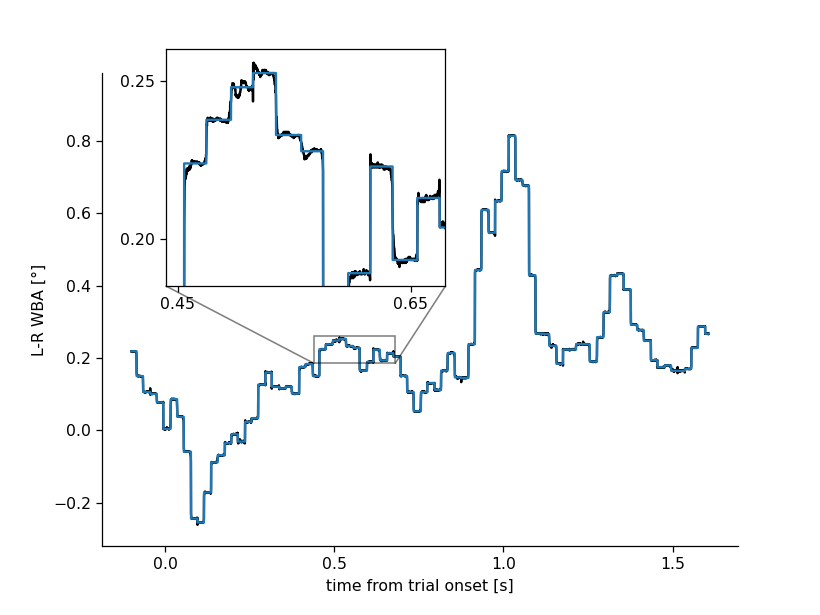

In [147]:
f,ax=plt.subplots(1,1)

t = anlyz.timeax
d = anlyz.segments[trialID].data[anlyz.channelmap['wingDiff']]
ax.plot(t[:d.size], d, 'k-')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('L-R WBA [°]')#
ax.set_xlabel('time from trial onset [s]')
ax.set_xticks([0.,0.5,1.0,1.5])

axins = ax.inset_axes([0.1, 0.55, 0.44, 0.5])
insetExtent = np.nonzero((t>0.44) & (t<0.68))[0]
axins.plot(t[insetExtent], d[insetExtent], 'k-', alpha=1.)
axins.set_ylim([0.185,0.26])
axins.set_xlim(t[insetExtent[[0,-1]]])
axins.set_yticks([0.2,0.25])
axins.set_xticks([0.45,0.65])

ax.indicate_inset_zoom(axins, edgecolor="black")

ax.plot(t[:yfit.size],yfit, '-', color=[31/255,119/255,180/255], alpha=1.)
axins.plot(t[insetExtent], yfit[insetExtent], '-', color=[31/255,119/255,180/255], alpha=1)

## Fig S1B

In [149]:
def central_diff_derivative(y, halfwidth=0.070, samplPeriod=0.020):
    """y is data to derivate, assumed to be np.array
    halfwidth and samplPeriod shall use the same unit (e.g. seconds)"""
    stepBack = int(halfwidth/samplPeriod+0.5)
    stepFwd = int(halfwidth/samplPeriod)
    return ( y[(stepFwd+stepBack):]-y[:-(stepBack+stepFwd)] )/((stepFwd+stepBack)*samplPeriod)

<IPython.core.display.Javascript object>


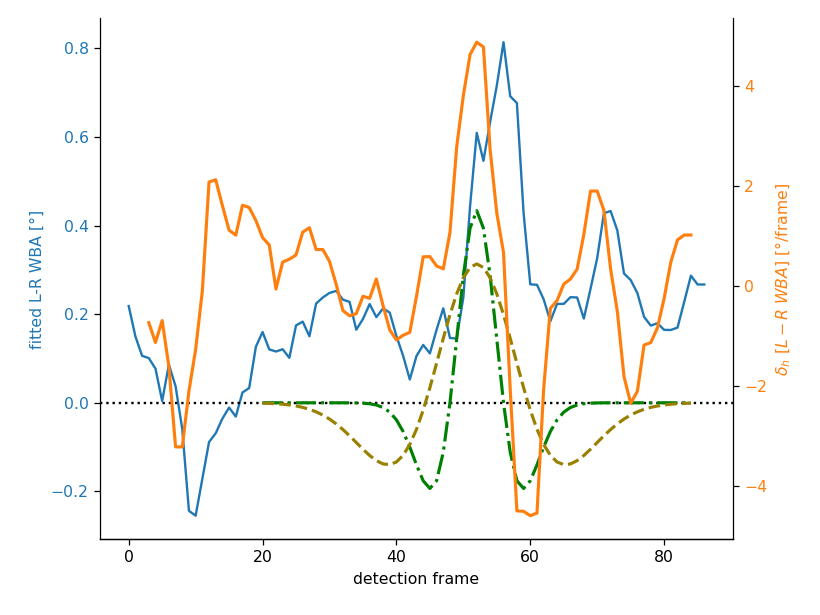

In [151]:
f,ax=plt.subplots(1,1)
ax2=ax.twinx()

medianFilterWidth = 3
diff_half_width = 0.05

detectSignal = signal.medfilt(ysteps,medianFilterWidth)
detectSignal = central_diff_derivative(detectSignal, diff_half_width, 0.02) #20 ms is Kinefly sampling period

ax.plot(ysteps, color='tab:blue')
ax2.plot(np.arange(int(diff_half_width/anlyz.kineflyPeriod+0.5),len(ysteps)-int(diff_half_width/anlyz.kineflyPeriod)) ,
         detectSignal, color='tab:orange', linewidth=2)

# add picture of wavelet
ax.axhline(0,linestyle=':', color='k')
scales = 2.**np.arange(2, 3., 1./16.)
offset = 52
ax.plot(np.arange(-32,32.1)+offset, signal.ricker(65,scales[0]), color=[0,0.5,0], linestyle='-.', linewidth=2)
ax.plot(np.arange(-32,32.1)+offset, signal.ricker(65,scales[-1]), color=[0.6,0.5,0], linestyle='--',linewidth=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('fitted L-R WBA [°]', color='tab:blue')
ax.tick_params(axis='y',labelcolor='tab:blue')

ax2.set_ylabel('$\delta_h\ [L-R\ WBA]$ [°/frame]', color='tab:orange')
ax2.tick_params(axis='y',labelcolor='tab:orange')

ax.set_xlabel('detection frame')
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()

## Fig S1C

<IPython.core.display.Javascript object>


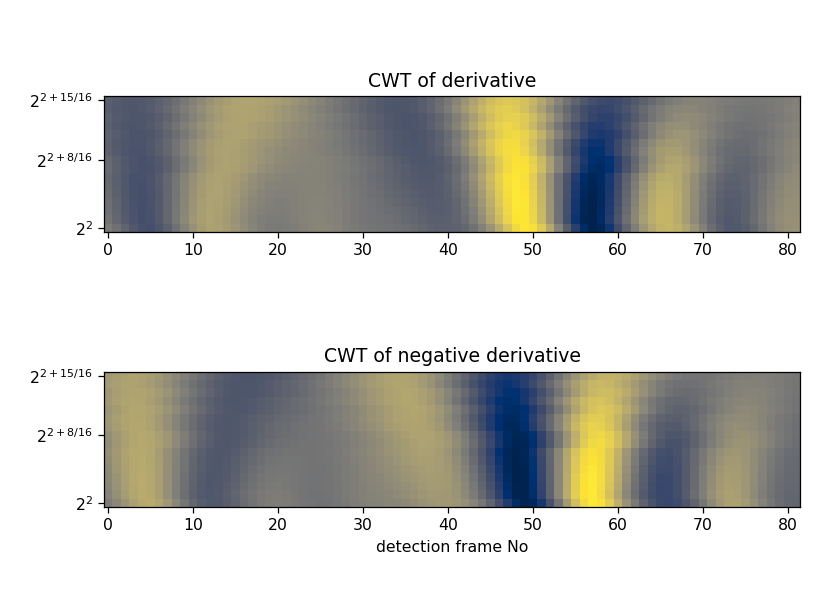

In [154]:
f,ax=plt.subplots(2,1)

scales = 2.**np.arange(2, 3., 1./16.)
detectSignal = signal.medfilt(ysteps,medianFilterWidth)
detectSignal = central_diff_derivative(detectSignal, diff_half_width, 0.02,)

# cwtSig = signal.cwt(ysteps,signal.ricker, scales)
cwtSig = signal.cwt(detectSignal,signal.ricker, scales)
# cwtSig,sj,freqs,coi,fft,fftfreqs = pycwt.cwt(detectSignal, 1, 1/16, s0=2,J=15, wavelet='mexicanhat')
# cwtSig= cwtSig.real
# ax[0].pcolormesh(cwtSig, cmap=plt.cm.coolwarm)
# im0=ax[0].pcolormesh(cwtSig, cmap=plt.cm.cividis, linewidth=0, rasterized=True)
# im0.set_edgecolor('face')
im0=ax[0].imshow(cwtSig, cmap=plt.cm.cividis, origin='lower')

cwtSig = signal.cwt(-detectSignal,signal.ricker, scales)
# im1=ax[1].pcolormesh(cwtSig, cmap=plt.cm.cividis, linewidth=0, rasterized=True)
# im1.set_edgecolor('face')
im1=ax[1].imshow(cwtSig, cmap=plt.cm.cividis, origin='lower')

# im0.set_clim([-0.5,0.5])
# im1.set_clim([-0.5,0.5])

# ax[0].set_yticklabels(['$2^{32/16}$','$2^{38/16}$','$2^{44/16}$', '$2^{50/16}$'])
# ax[0].set_yticklabels(['$2^2$','$2^{2+5/16}$','$2^{2+10/16}$', '$2^{2+15/16}$'])
# ax[0].set_yticks([0,8,16])
# ax[0].set_yticklabels(['$2^2$','$2^{2+8/16}$','$2^{2+16/16}$'])
ax[0].set_yticks([0,8,15])
ax[0].set_yticklabels(['$2^2$','$2^{2+8/16}$','$2^{2+15/16}$'])
# ax[1].set_yticks([0,8,16])
# ax[1].set_yticklabels(['$2^2$','$2^{2+8/16}$','$2^{2+16/16}$'])
ax[1].set_yticks([0,8,15])
ax[1].set_yticklabels(['$2^2$','$2^{2+8/16}$','$2^{2+15/16}$'])
# ax[0].set_title('CWT of signal')
ax[0].set_title('CWT of derivative')
# ax[1].set_title('CWT of inverse signal')
ax[1].set_title('CWT of negative derivative')
ax[1].set_xlabel('detection frame No')
# try 3d plot
# f=plt.figure()
# a0=f.add_subplot(projection='3d')
# a1=f.add_subplot(projection='3d')
# ax=[a0,a1]
# X,Y = np.meshgrid(np.arange(len(ysteps)), scales )
# a0.plot_surface(X,Y,cwtSig, cmap=plt.cm.coolwarm)

plt.tight_layout()

## Fig S1D
Needs additional function declarations to redo the saccade detection as it happens in the analysis algorithm. Disentagle overlapping point markers later in Inkscape.

In [158]:
def lowPass(y, samplingRate):
    fThresh = 6.#Hz
    #b,a=signal.butter(5,6.,fs=samplingRate, btype='low')
    #ylow = signal.lfilter(b,a,y)
    b,a=signal.butter(5,6.*1.5,fs=samplingRate, btype='low')
    ylow = signal.filtfilt(b,a,y)
    return ylow

def central_diff_derivative(y, halfwidth=0.070, samplPeriod=0.020):
    """y is data to derivate, assumed to be np.array
    halfwidth and samplPeriod shall use the same unit (e.g. seconds)"""
    stepBack = int(halfwidth/samplPeriod+0.5)
    stepFwd = int(halfwidth/samplPeriod)
    return ( y[(stepFwd+stepBack):]-y[:-(stepBack+stepFwd)] )/((stepFwd+stepBack)*samplPeriod)

def highpass_data(y, samplingRate):
    # highpass data
    b,a = signal.butter(5, 1., fs=samplingRate, btype='high')
    yhigh = signal.lfilter(b,a,y)
    return yhigh

def plotHighLowPass(y, yhigh, ylow=None):
    f,ax=plt.subplots(1,1)
    ax.plot(y)
    ax.plot(yhigh)
    if not ylow is None:
        ax.plot(ylow)
    ax.legend(['original','highpass', 'lowpass'])
    return ax

def extractFlyStatistics(y, samplingRate, plot=True, **kwargs):
    yhigh = highpass_data(y, samplingRate)
    pdf, bins = np.histogram(yhigh, bins=50)
    pdf = pdf/pdf.sum()
    cdf = np.cumsum(pdf)
    thresh = kwargs.get('thresh',0.95)
    binCenters = (bins[:-1]+bins[1:])/2

    minIdx = np.argmin(np.abs(cdf-thresh))
    theta = binCenters[minIdx]
    
    if plot:
        f,ax=plt.subplots(1,1)
        ax.plot(binCenters, pdf)
        ax.plot(binCenters, cdf)
        ax.plot(binCenters[minIdx],cdf[minIdx], 'go')
        ax.plot(binCenters[minIdx],pdf[minIdx], 'ro')
        ax.axhline(0.9, color='k', linestyle=':')
        ax.axvline(theta, color='r')
    return theta

def detectPeaks(theta, ydiff):
    detectTheta = theta*6. #as stated in paper
    peaksFound = signal.find_peaks(np.abs(ydiff), height=detectTheta)
    return peaksFound

def plotDetection(ax,ydiff, detectTheta):
    ax.plot(ydiff)
    ax.axhline(detectTheta, color='k')    
    ax.axhline(0, color='g')
    return
    
# find peak times
def findPeakTimes(ydiff, peaksFound):
    ## for each peak, move FORWARD till encountering closest to 0
    peakTime = np.full_like(peaksFound, np.nan, dtype=int)
    for j,p in enumerate(peaksFound):
        #compare the signs, because peaks can be + or - (at 0 it switches)
        sameSign = True
        i=0
        while sameSign>0:
            i+=1
            if p+i >=ydiff.size:
                i -=1 #plug right value for line after while loop
                break
            sameSign = (ydiff[p+i]*ydiff[p+i-1])>0. 
        if p+i <ydiff.size:
            thisPeak = p+i-1 + np.argmin(np.abs(ydiff[[p+i-1,p+i]]))
        else:
            thisPeak = ydiff.size
        peakTime[j] = int(thisPeak)
    return peakTime

# find onset times
def findOnsetTime(ydiff, peaksFound):
    ## for each peak, move BACKWARD till encountering closest to 0
    onsetTime = np.zeros_like(peaksFound, dtype=int)
    for j,p in enumerate(peaksFound):
        sameSign = True
        i=-0
        while sameSign>0:
            i-=1
            if p+i<0:
                i+=1 #plug right value for line after while loop
                break
            sameSign = (ydiff[p+i]*ydiff[p+i+1])>0. #compare the signs, because peaks can be + or - (at 0 it switches)
        if p+i >=0:
            thisOnset = p+i + np.argmin(np.abs(ydiff[[p+i,p+i+1]]))
        else:
            thisOnset=0
        onsetTime[j] = int(thisOnset)
    return onsetTime

# correct onset times for error introduced by lowpass filtering
def correctOnsetTime(y,ylow, ydiff, peaksFound, onsetTime):
    actualOnset = np.full_like(onsetTime, np.nan, dtype=int)
    for j,o in enumerate(onsetTime):
        ## use value of low-passed L-R WBA at putative onset as threshold
        thresh = ylow[o]
        ## look forward in original signal from putative onset and find last sample before threshold
        ytemp = y-thresh #this turns it into finding a 0-crossing (like above)
        ### shortcut to deal with cases where actual onset is not included in trace
        p = peaksFound[j]
        if not any(np.diff(np.sign(ytemp[o:p]))):
            #no change in sign means no threshold crossing
            actualOnset[j] = o #keep putataive one
            continue
        sameSign=True
        i=0
        while sameSign:
            i+=1
            sameSign = (ytemp[o+i]*ytemp[o+i-1])>0.
        ## define this as actual onset
        actualOnset[j] = o+1-1
    return actualOnset

## get saccade amplitudes
def getSaccadeAmplitude(y, peaksFound, actualOnset, samplingRate):
    #subtracted the mean L-R WBA signal 50-ms baseline interval before saccade onset 
    #from mean L-R WBA signal in +-15-ms windows surrounding the peak
    saccAmp = np.full(peaksFound.size, np.nan, dtype=np.float)
    for i in range(len(actualOnset)):
        baseline = np.mean(y[actualOnset[i]-int(0.06*samplingRate) : actualOnset[i]])
        if not np.isnan(baseline):
            saccAmp[i] =  np.mean( y[peaksFound[i]-int(0.03*samplingRate) : peaksFound[i]+int(0.03*samplingRate)] ) - baseline    
    return saccAmp

def plotPeaks(y, actualOnset, peakTime, saccAmp, ax=None):
    if ax is None:
        f,ax=plt.subplots(1,1)
        ax.plot(y)
    ax.plot(actualOnset, y[actualOnset], 'r>')
    ax.plot(peakTime, y[peakTime], 'k^')
    ax.plot(peakTime, saccAmp, 'ko')
    return

# eliminate putative saccade if maximal deviation before onset is>55% of amplitude
def eliminateByDeviation(y, actualOnset, saccAmp, samplingRate, **kwargs):
    window = kwargs.get('window',0.201)
    deviationLimit = kwargs.get('deviationLimit',0.55)
    toEliminate = []
    for i in range(actualOnset.size):
        # preselect to make sure the indexing is feasible
        chunk = y[actualOnset[i]-int(window*samplingRate) : actualOnset[i]]
        if actualOnset[i]-int(window*samplingRate) <0:
            toEliminate.append(i)
            continue
        deviation = chunk.max()-chunk.min()
        if deviation>deviationLimit*abs(saccAmp[i]):
            toEliminate.append(i)
    return toEliminate

def eliminateByPeakProximity(onset,saccAmp,*, samplingRate=10000, timeDist:float=0.5) ->list:
    '''eliminate peaks that are too close to one another. 
    This is intended particularly for when they go in opposite direction, 
    such that the second could well be end of the first
    Note: we don't need absolute times because operating inside segments
    This is instance three, considering only distances between saccades if they are in opposite directions'''
    #make sure they are sorted
    onset.sort()
    peakTime.sort()
    # iterate forward, check distance to previous 
    toEliminate = []
    for i in range(1,onset.size):
        if saccAmp[i]*saccAmp[i-1] >0:#sign check, same saccade direction
            continue
        current=onset[i]
        prev = onset[i-1]
        # if it's too short, eliminate
        assert(not current-prev<0)
        if current-prev < timeDist*samplingRate :
            toEliminate.append(i)
    return toEliminate

def eliminateBySaccAmplitude(saccAmp, thresh)->list:
    toEliminate=[]
    for i in range(0,saccAmp.size):
        if abs(saccAmp[i])< thresh:
            toEliminate.append(i)
    return toEliminate

def eliminatePutativePersistent(cwtpeaks,peakTime,maxPeakDelay,onset,maxOnsetDelay, samplingPeriod):
    # eliminate if the onset or peak are too far away from the peak in derivative
    toEliminate = []
    for i in range(cwtpeaks.size):
        if cwtpeaks[i]-onset[i]>maxOnsetDelay/samplingPeriod:#don't know yet how big this hsould be
            toEliminate.append(i)
        elif peakTime[i]-cwtpeaks[i]>maxPeakDelay/samplingPeriod:
            toEliminate.append(i)
    return toEliminate

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
    return

<IPython.core.display.Javascript object>


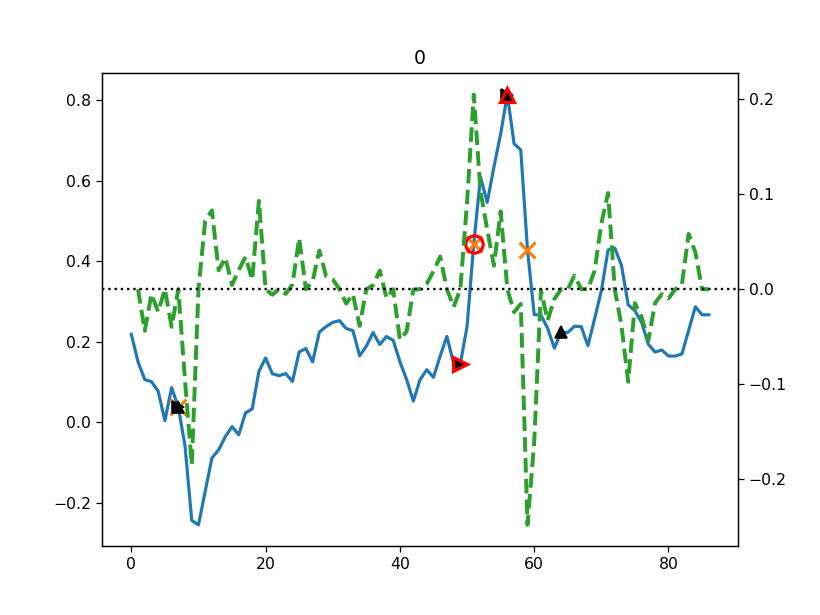

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


"detectionParams = {'method':'CWT',\n                  'scales': scales,\n                  'diff_half_width': diff_half_width,\n                  'medianFilterWidth': medianFilterWidth,\n                  'CWTpeaks_window_size':cwtpeaks_window_size,\n                   'deviationWindow':deviationWindow,\n                   'deviationLimit': deviationLimit,\n                   'saccAmpThreshold': saccAmpThreshold,\n                   'minPeakInterval':minPeakInterval,\n                   'maxPeakDelay': maxPeakDelay,\n                   'maxOnsetDelay': maxOnsetDelay,\n                   'cascadeFiltering': cascadeFiltering\n                  }\n"

In [162]:
#saccDataCWT = {}

scales = 2.**np.arange(2, 3., 1./16.)
diff_half_width = 0.05 #0.05
medianFilterWidth = 3
cwtpeaks_window_size = 20
deviationWindow = 0.16 #0.16
deviationLimit = 0.65 # was 0.55 for spont
saccAmpThreshold = 15.*np.pi/180
minPeakInterval = 0.1
cascadeFiltering = True
maxPeakDelay = 1.2#s
maxOnsetDelay =  1.1#s

f,ax=plt.subplots(1,1)
ax2 = ax.twinx()

for i in [trialID]: #replace iteration by length-1-list for this plot
    _,_,ysteps = helperLibrary.straightLineFiltering(anlyz.segments[trialID].data[anlyz.channelmap['wingDiff']],
                                                     0.020*anlyz.samplingRate, postEnhancement=True )
    y=ysteps
    detectSignal = signal.medfilt(y,medianFilterWidth)
    detectSignal = central_diff_derivative(detectSignal, diff_half_width, 0.02)
    ax2.plot(range(1,y.size), np.diff(signal.medfilt(y,medianFilterWidth)), color='tab:green',
             label='differential', linestyle='--', linewidth=2.5)
    
    ax2.axhline(0, color='k',linestyle=':')
    peaks = signal.find_peaks_cwt(detectSignal, scales, gap_thresh=1, 
                                  window_size=cwtpeaks_window_size, noise_perc=5)
    peaks2 = signal.find_peaks_cwt(-detectSignal, scales, gap_thresh=1, 
                                   window_size=cwtpeaks_window_size, noise_perc=5)
    peaks = np.concatenate((peaks,peaks2))
    peaks.sort() #sorts in-place
    peaks = peaks.astype('int')
    peaks += int(diff_half_width/anlyz.kineflyPeriod)
    peakTime = findPeakTimes(np.diff(signal.medfilt(y,medianFilterWidth)), peaks-1) +1 #plus 1 to correct diff shift
    onsetTime = findOnsetTime(np.diff(signal.medfilt(y,medianFilterWidth)), peaks-1) +1
    saccAmp = getSaccadeAmplitude(y, peakTime, onsetTime, 1/anlyz.kineflyPeriod)

    # plot detection before filtering
    ax.plot(y, linewidth=2)
    ax.plot(peaks, y[peaks], 'x',color='tab:orange', markersize=10, markeredgewidth=2, label='differential peak')
    ax.plot(peakTime, y[peakTime], '^', color='k', markersize=8, label='candidate peak')
    ax.plot(onsetTime, y[onsetTime], '>', color='k', markersize=8, label='candidate onset')

    #start filtering stage
    keep = np.ones_like(peaks,dtype=bool)
    elim = eliminateBySaccAmplitude(saccAmp, saccAmpThreshold)
    keep[elim]=False
    if cascadeFiltering:
        peaks = peaks[keep]
        peakTime = peakTime[keep]
        onsetTime = onsetTime[keep]
        saccAmp = saccAmp[keep]
        keep = np.ones_like(peaks,dtype=bool)
    
    elim = eliminateByPeakProximity(onsetTime, saccAmp, samplingRate=1/anlyz.kineflyPeriod,
                                     timeDist=minPeakInterval)
    keep[elim]=False
    #combine with next step
    #these two steps are similar, therefore combine together
    elim = eliminateByDeviation(y, onsetTime, saccAmp, 1/anlyz.kineflyPeriod, 
                                window=deviationWindow, deviationLimit=deviationLimit)
    keep[elim]=False
    if cascadeFiltering:
        peaks = peaks[keep]
        peakTime = peakTime[keep]
        onsetTime = onsetTime[keep]
        saccAmp = saccAmp[keep]
        keep = np.ones_like(peaks,dtype=bool)
    
    
    elim = eliminatePutativePersistent(peaks, peakTime,maxPeakDelay, onsetTime,maxOnsetDelay, anlyz.kineflyPeriod)
    keep[elim]=False
    ax.plot(peaks[keep], y[peaks[keep]], 'o',color='r', markerfacecolor="None", 
            markeredgewidth=2, markersize=11)
    ax.plot(peakTime[keep], y[peakTime[keep]], '^',color='r',markeredgewidth=2,
            markerfacecolor="None", markersize=9, label='definitive peak')
    ax.plot(onsetTime[keep], y[onsetTime[keep]], '>',color='r',markeredgewidth=2,
            markerfacecolor="None", markersize=9, label='definitive onset')
    ax.set_title(trialID)

    peaks = peaks[keep]
    peakTime = peakTime[keep]
    onsetTime = onsetTime[keep]
    saccAmp = saccAmp[keep]
    
#     saccDataCWT[i] = dict([('peakTime',peakTime),('onset',onsetTime), ('saccAmp',saccAmp), ('CWTpeaks',peaks)])
"""detectionParams = {'method':'CWT',
                  'scales': scales,
                  'diff_half_width': diff_half_width,
                  'medianFilterWidth': medianFilterWidth,
                  'CWTpeaks_window_size':cwtpeaks_window_size,
                   'deviationWindow':deviationWindow,
                   'deviationLimit': deviationLimit,
                   'saccAmpThreshold': saccAmpThreshold,
                   'minPeakInterval':minPeakInterval,
                   'maxPeakDelay': maxPeakDelay,
                   'maxOnsetDelay': maxOnsetDelay,
                   'cascadeFiltering': cascadeFiltering
                  }
"""